# Bibliotecas

In [ ]:
!pip install optuna
!git clone https://github.com/AI-thpremed/TabKANet.git
%cd TabKANet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 29.5 MB/s eta 0:00:00
Cloning into 'TabKANet'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 159 (delta 68), reused 125 (delta 47), pack-reused 0 (from 0)
Receiving objects: 100% (159/159), 9.61 MiB | 6.08 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content/TabKANet


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from google.colab import drive

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from scipy.stats import ks_2samp

from torch.utils.data import Dataset, DataLoader
from tabkanet.models import TabKANet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)


# Extração dos dados

In [ ]:
drive.mount('/content/drive')
DATA_DIR = '/content/drive/MyDrive/data_sets_classificacao_churn'

Mounted at /content/drive


In [ ]:
X_train = pd.read_csv(f"{DATA_DIR}/X_train_over.csv")
y_train = pd.read_csv(f"{DATA_DIR}/y_train_over.csv")

X_val = pd.read_csv(f"{DATA_DIR}/X_val_over.csv")
y_val = pd.read_csv(f"{DATA_DIR}/y_val_over.csv")

X_test = pd.read_csv(f"{DATA_DIR}/X_test.csv")
y_test = pd.read_csv(f"{DATA_DIR}/y_test.csv")

# Funções

In [ ]:
def compute_metrics(y_true, y_prob):
    y_pred = (y_prob > 0.5).astype(int)
    ks, _ = ks_2samp(y_prob[y_true == 1], y_prob[y_true == 0])

    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "auc": roc_auc_score(y_true, y_prob),
        "ks": ks
    }


In [ ]:
def prepare_features(X_train, X_val, X_test, cont_cols):

    cat_cols = [c for c in X_train.columns if c not in cont_cols]

    # vocabulário categórico
    vocab = {}
    for col in cat_cols:
        values = X_train[col].astype(str).unique()
        vocab[col] = {v: i for i, v in enumerate(values)}
        vocab[col]["__UNK__"] = len(vocab[col])

    scaler = StandardScaler()
    X_train_cont = scaler.fit_transform(X_train[cont_cols])
    X_val_cont   = scaler.transform(X_val[cont_cols])
    X_test_cont  = scaler.transform(X_test[cont_cols])

    def encode_cat(df):
        out = []
        for _, row in df[cat_cols].iterrows():
            out.append([
                vocab[col].get(str(row[col]), vocab[col]["__UNK__"])
                for col in cat_cols
            ])
        return np.array(out)

    X_train_cat = encode_cat(X_train)
    X_val_cat   = encode_cat(X_val)
    X_test_cat  = encode_cat(X_test)

    return (
        X_train_cat, X_train_cont,
        X_val_cat,   X_val_cont,
        X_test_cat,  X_test_cont,
        vocab, scaler, cat_cols
    )


In [ ]:
class TabDataset(Dataset):
    def __init__(self, x_cat, x_cont, y):
        self.x_cat = torch.tensor(x_cat, dtype=torch.long)
        self.x_cont = torch.tensor(x_cont, dtype=torch.float32)
        self.y = torch.tensor(y.values.squeeze(), dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x_cat[idx], self.x_cont[idx], self.y[idx]


In [ ]:
def train_model(model, train_loader, val_loader, epochs=10):

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    best_ks = -1
    best_state = None

    for epoch in range(epochs):

        model.train()
        for x_cat, x_cont, y in train_loader:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(x_cat, x_cont.to(device))

            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

        # validação
        model.eval()
        probs, labels = [], []

        with torch.no_grad():
            for x_cat, x_cont, y in val_loader:
                x_cat, x_cont = x_cat.to(device), x_cont.to(device)
                out = model(x_cat, x_cont)
                p = torch.softmax(out, dim=1)[:, 1]

                probs.extend(p.cpu().numpy())
                labels.extend(y.numpy())

        metrics = compute_metrics(np.array(labels), np.array(probs))

        print(
            f"Epoch {epoch+1} | "
            f"KS: {metrics['ks']:.4f} | "
            f"AUC: {metrics['auc']:.4f}"
        )

        if metrics["ks"] > best_ks:
            best_ks = metrics["ks"]
            best_state = model.state_dict()

    model.load_state_dict(best_state)
    return model


In [ ]:
def evaluate(model, loader):
    model.eval()
    probs, labels = [], []

    with torch.no_grad():
        for x_cat, x_cont, y in loader:
            x_cat, x_cont = x_cat.to(device), x_cont.to(device)
            out = model(x_cat, x_cont.to(device))

            p = torch.softmax(out, dim=1)[:, 1]
            probs.extend(p.cpu().numpy())
            labels.extend(y.numpy())

    return compute_metrics(np.array(labels), np.array(probs))


In [ ]:
def make_bins(X_cont, num_cont, n_bins=10):
    assert X_cont.shape[1] == num_cont, "X_cont e num_cont não batem"

    bins = np.zeros((num_cont, n_bins + 1))
    for i in range(num_cont):
        q = np.quantile(X_cont[:, i], np.linspace(0, 1, n_bins + 1))
        bins[i] = q

    return torch.tensor(bins, dtype=torch.float32)


In [ ]:
def plot_model_diagnostics(
    y_true,
    y_score,
    threshold=0.5,
    title_prefix="Modelo"
):
    y_true = np.array(y_true)
    y_score = np.array(y_score)

    # KS CUMULATIVE CURVE
    order = np.argsort(y_score)[::-1]
    y_sorted = y_true[order]

    n_pos = np.sum(y_sorted == 1)
    n_neg = np.sum(y_sorted == 0)

    cum_pos = np.cumsum(y_sorted == 1) / n_pos
    cum_neg = np.cumsum(y_sorted == 0) / n_neg

    ks_values = np.abs(cum_pos - cum_neg)
    ks = np.max(ks_values)
    ks_pos = np.argmax(ks_values)

    plt.figure(figsize=(8, 6))
    plt.plot(cum_pos, label="TPR (Cumulativo)")
    plt.plot(cum_neg, label="FPR (Cumulativo)")
    plt.axvline(
        ks_pos,
        color="red",
        linestyle="--",
        label=f"KS = {ks:.3f}"
    )
    plt.xlabel("Amostras ordenadas pelo score")
    plt.ylabel("Taxa acumulada")
    plt.title(f"Curva KS")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ROC CURVE
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)

    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Curva ROC")
    plt.legend()
    plt.grid(True)
    plt.show()

    # CONFUSION MATRIX
    y_pred = (y_score >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Classe 0", "Classe 1"],
        yticklabels=["Classe 0", "Classe 1"]
    )
    plt.title(f"Matriz de Confusão")
    plt.xlabel("Predição")
    plt.ylabel("Real")
    plt.show()

    return {
        "ks": ks,
        "auc": auc,
        "threshold": threshold
    }


# Experimento 1 - Treinamento Inicial com modelo mais simples

In [ ]:
cont_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

(
    Xtr_cat, Xtr_cont,
    Xv_cat,  Xv_cont,
    Xt_cat,  Xt_cont,
    vocab, scaler, cat_cols
) = prepare_features(X_train, X_val, X_test, cont_cols)

num_cont = Xtr_cont.shape[1]
bins = make_bins(Xtr_cont, num_cont=Xtr_cont.shape[1], n_bins=4).to(device)



train_ds = TabDataset(Xtr_cat, Xtr_cont, y_train)
val_ds   = TabDataset(Xv_cat,  Xv_cont,  y_val)
test_ds  = TabDataset(Xt_cat,  Xt_cont,  y_test)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=512)
test_loader  = DataLoader(test_ds, batch_size=512)

assert bins.shape[0] == Xtr_cont.shape[1], \
    f"Bins {bins.shape} ≠ num_cont {Xtr_cont.shape[1]}"

model = TabKANet(
        output_dim=2,
        vocabulary=vocab,
        num_continuous_features=Xtr_cont.shape[1],
        embedding_dim=32,
        nhead=4,
        num_layers=1,
        dim_feedforward=64,
        mlp_hidden_dims=[32],
        activation="gelu",
        ffn_dropout_rate=0.1,
        attn_dropout_rate=0.1,
        learninable_noise=True,
        bins=bins
    ).to(device)
model = train_model(model, train_loader, val_loader, epochs=15)

test_metrics = evaluate(model, test_loader)
print("\nTeste final:", test_metrics)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 1 | KS: 0.5280 | AUC: 0.8370
Epoch 2 | KS: 0.5365 | AUC: 0.8414
Epoch 3 | KS: 0.5450 | AUC: 0.8435
Epoch 4 | KS: 0.5443 | AUC: 0.8442
Epoch 5 | KS: 0.5520 | AUC: 0.8431
Epoch 6 | KS: 0.5210 | AUC: 0.8350
Epoch 7 | KS: 0.5334 | AUC: 0.8418
Epoch 8 | KS: 0.5311 | AUC: 0.8414
Epoch 9 | KS: 0.5505 | AUC: 0.8408
Epoch 10 | KS: 0.5466 | AUC: 0.8419
Epoch 11 | KS: 0.5241 | AUC: 0.8305
Epoch 12 | KS: 0.5349 | AUC: 0.8400
Epoch 13 | KS: 0.5365 | AUC: 0.8366
Epoch 14 | KS: 0.5419 | AUC: 0.8365
Epoch 15 | KS: 0.5427 | AUC: 0.8397

Teste final: {'accuracy': 0.7672561323445521, 'auc': np.float64(0.8448557403325987), 'ks': np.float64(0.5298003072196621)}


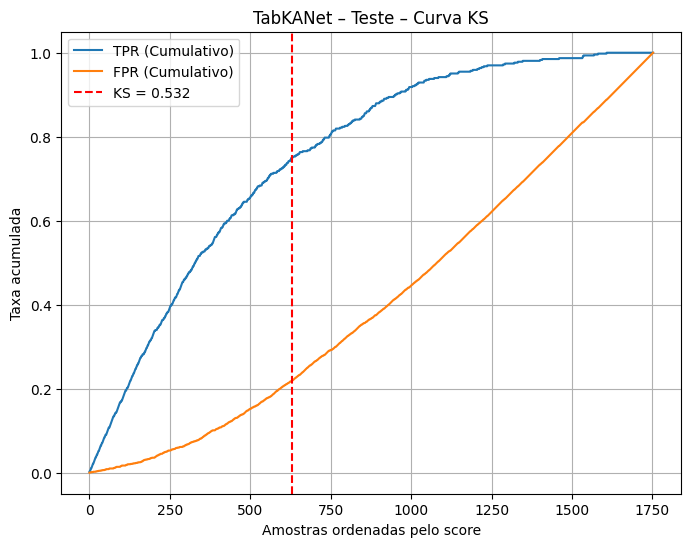

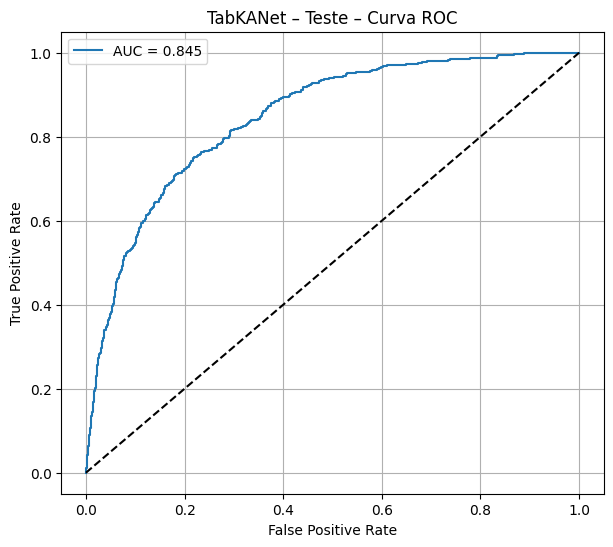

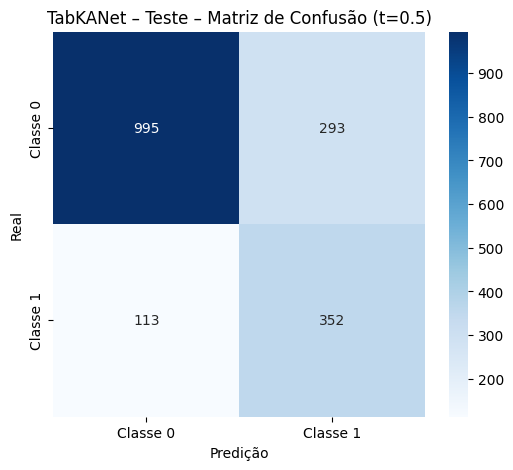

{'ks': np.float64(0.532369932545248), 'auc': np.float64(0.8452497829426299), 'threshold': 0.5}


In [ ]:
model.eval()
probs, labels = [], []

with torch.no_grad():
    for x_cat, x_cont, y in test_loader:
        x_cat, x_cont = x_cat.to(device), x_cont.to(device)

        logits = model(x_cat, x_cont)
        p = torch.softmax(logits, dim=1)[:, 1]

        probs.extend(p.cpu().numpy())
        labels.extend(y.numpy())

y_prob = np.array(probs)
y_true = np.array(labels)

metrics = plot_model_diagnostics(
    y_true=y_true,
    y_score=y_prob,
    threshold=0.5,
    title_prefix="TabKANet – Teste"
)

print(metrics)

# Experimento 2 - Treinamento com otimização de Hiperparâmetros

In [ ]:
def train_eval_tabkan(trial):

    embedding_dim = trial.suggest_categorical("embedding_dim", [16, 32, 64])
    nhead         = trial.suggest_categorical("nhead", [2, 4, 8])
    num_layers    = trial.suggest_int("num_layers", 1, 3)
    dim_ff        = trial.suggest_categorical("dim_feedforward", [64, 128, 256])
    mlp_dim       = trial.suggest_categorical("mlp_hidden", [32, 64, 128])

    lr            = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    weight_decay  = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    batch_size    = trial.suggest_categorical("batch_size", [128, 256, 512])

    # loaders dinâmicos
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=512)

    model = TabKANet(
        output_dim=2,
        vocabulary=vocab,
        num_continuous_features=Xtr_cont.shape[1],
        embedding_dim=embedding_dim,
        nhead=nhead,
        num_layers=num_layers,
        dim_feedforward=dim_ff,
        mlp_hidden_dims=[mlp_dim],
        activation="gelu",
        attn_dropout_rate=0.1,
        ffn_dropout_rate=0.1,
        learninable_noise=True,
        bins=bins
    ).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )

    criterion = nn.CrossEntropyLoss()

    # treino curto (anti-overfit do Optuna)
    for _ in range(7):
        model.train()
        for x_cat, x_cont, y in train_loader:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x_cat, x_cont), y)
            loss.backward()
            optimizer.step()

    # validação
    model.eval()
    probs, labels = [], []

    with torch.no_grad():
        for x_cat, x_cont, y in val_loader:
            x_cat, x_cont = x_cat.to(device), x_cont.to(device)
            p = torch.softmax(model(x_cat, x_cont), dim=1)[:, 1]
            probs.extend(p.cpu().numpy())
            labels.extend(y.numpy())

    ks, _ = ks_2samp(
        np.array(probs)[np.array(labels) == 1],
        np.array(probs)[np.array(labels) == 0]
    )

    return ks


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(train_eval_tabkan, n_trials=20)

print("Melhor KS:", study.best_value)
print("Melhores hiperparâmetros:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")

[I 2025-12-18 17:36:00,588] A new study created in memory with name: no-name-65bf4594-f2f6-41bb-ae4b-9deb9860b41e
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
[I 2025-12-18 17:36:03,089] Trial 0 finished with value: 0.5481366459627329 and parameters: {'embedding_dim': 32, 'nhead': 4, 'num_layers': 3, 'dim_feedforward': 64, 'mlp_hidden': 64, 'lr': 0.0007101884612225746, 'weight_decay': 3.997876089456566e-05, 'batch_size': 512}. Best is trial 0 with value: 0.5481366459627329.
[I 2025-12-18 17:36:05,827] Trial 1 finished with value: 0.5574534161490683 and parameters: {'embedding_dim': 16, 'nhead': 8, 'num_layers': 2, 'dim_feedforward': 256, 'mlp_hidden': 128, 'lr': 0.0028840259617116015, 'weight_decay': 0.00019437896501279283, 'batch_size': 512}. Best is trial 1 with value: 0.5574534161490683.
[I 2025-12-18 17:36:08,875] 

Melhor KS: 0.562111801242236
Melhores hiperparâmetros:
embedding_dim: 32
nhead: 4
num_layers: 1
dim_feedforward: 256
mlp_hidden: 64
lr: 0.00046501760914590334
weight_decay: 2.0108768136180102e-06
batch_size: 256


In [ ]:
best_params = study.best_params
print(best_params)

{'embedding_dim': 32, 'nhead': 4, 'num_layers': 1, 'dim_feedforward': 256, 'mlp_hidden': 64, 'lr': 0.00046501760914590334, 'weight_decay': 2.0108768136180102e-06, 'batch_size': 256}


In [ ]:
trainval_ds = ConcatDataset([train_ds, val_ds])

trainval_loader = DataLoader(
    trainval_ds,
    batch_size=best_params["batch_size"],
    shuffle=True
)

test_loader = DataLoader(test_ds, batch_size=512)


In [ ]:
def evaluate_ks(model, loader):
    model.eval()
    probs, labels = [], []

    with torch.no_grad():
        for x_cat, x_cont, y in loader:
            x_cat, x_cont = x_cat.to(device), x_cont.to(device)

            logits = model(x_cat, x_cont)
            p = torch.softmax(logits, dim=1)[:, 1]

            probs.extend(p.cpu().numpy())
            labels.extend(y.numpy())

    y_true = np.array(labels)
    y_prob = np.array(probs)

    ks = ks_2samp(y_prob[y_true == 1], y_prob[y_true == 0]).statistic
    return ks


In [ ]:
# ─── Modelo ────────────────────────────────────────────────
model = TabKANet(
    output_dim=2,
    vocabulary=vocab,
    num_continuous_features=Xtr_cont.shape[1],
    embedding_dim=best_params["embedding_dim"],
    nhead=best_params["nhead"],
    num_layers=best_params["num_layers"],
    dim_feedforward=best_params["dim_feedforward"],
    mlp_hidden_dims=[best_params["mlp_hidden"]],
    activation="gelu",
    attn_dropout_rate=0.1,
    ffn_dropout_rate=0.1,
    learninable_noise=True,
    bins=bins
).to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=best_params["lr"],
    weight_decay=best_params["weight_decay"]
)

criterion = nn.CrossEntropyLoss()

# ─── Early Stopping ────────────────────────────────────────
PATIENCE = 5
best_val_loss = float("inf")
best_state = None
epochs_no_improve = 0

EPOCHS = 30

# ─── Loop de Treino ────────────────────────────────────────
for epoch in range(EPOCHS):

    # ─── Treino ───────────────────────────────────────────
    model.train()
    train_loss = 0.0

    for x_cat, x_cont, y in trainval_loader:
        x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x_cat, x_cont)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(trainval_loader)

    # ─── Validação (LOSS + KS) ─────────────────────────────
    model.eval()
    val_loss = 0.0
    probs, labels = [], []

    with torch.no_grad():
        for x_cat, x_cont, y in val_loader:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)

            logits = model(x_cat, x_cont)
            loss = criterion(logits, y)
            val_loss += loss.item()

            p = torch.softmax(logits, dim=1)[:, 1]
            probs.extend(p.cpu().numpy())
            labels.extend(y.cpu().numpy())

    val_loss /= len(val_loader)

    # KS apenas como métrica
    val_ks = ks_2samp(
        np.array(probs)[np.array(labels) == 1],
        np.array(probs)[np.array(labels) == 0]
    )[0]

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val KS: {val_ks:.4f}"
    )

    # ─── Early Stopping (baseado no ERRO) ──────────────────
    if val_loss < best_val_loss - 1e-4:  # tolerância numérica
        best_val_loss = val_loss
        best_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping ativado na epoch {epoch+1}")
        break

# ─── Restaurar melhor modelo ──────────────────────────────
model.load_state_dict(best_state)


Epoch 1/30 | Train Loss: 0.5371 | Val Loss: 0.5071 | Val KS: 0.5365
Epoch 2/30 | Train Loss: 0.4979 | Val Loss: 0.4687 | Val KS: 0.5582
Epoch 3/30 | Train Loss: 0.4869 | Val Loss: 0.4548 | Val KS: 0.5800
Epoch 4/30 | Train Loss: 0.4816 | Val Loss: 0.4634 | Val KS: 0.5792
Epoch 5/30 | Train Loss: 0.4756 | Val Loss: 0.4629 | Val KS: 0.5901
Epoch 6/30 | Train Loss: 0.4661 | Val Loss: 0.4538 | Val KS: 0.5932
Epoch 7/30 | Train Loss: 0.4673 | Val Loss: 0.4428 | Val KS: 0.6071
Epoch 8/30 | Train Loss: 0.4652 | Val Loss: 0.4489 | Val KS: 0.6335
Epoch 9/30 | Train Loss: 0.4579 | Val Loss: 0.4723 | Val KS: 0.6056
Epoch 10/30 | Train Loss: 0.4590 | Val Loss: 0.4348 | Val KS: 0.6134
Epoch 11/30 | Train Loss: 0.4482 | Val Loss: 0.4284 | Val KS: 0.6343
Epoch 12/30 | Train Loss: 0.4526 | Val Loss: 0.4284 | Val KS: 0.6180
Epoch 13/30 | Train Loss: 0.4547 | Val Loss: 0.4321 | Val KS: 0.6250
Epoch 14/30 | Train Loss: 0.4472 | Val Loss: 0.4535 | Val KS: 0.6359
Epoch 15/30 | Train Loss: 0.4410 | Val Loss

<All keys matched successfully>

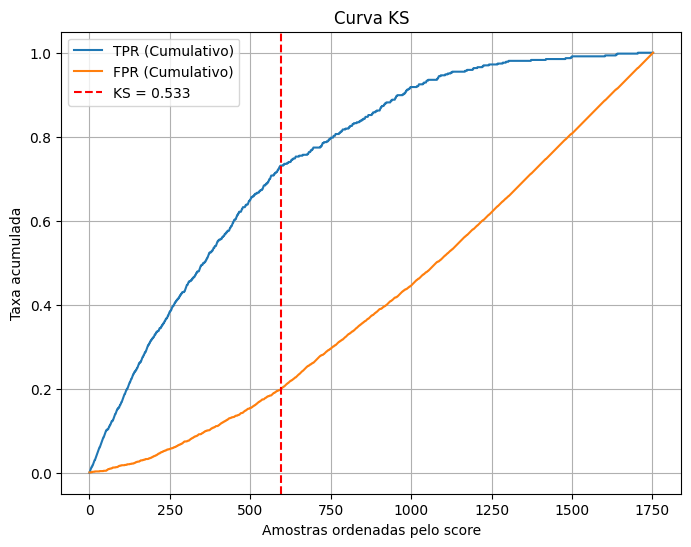

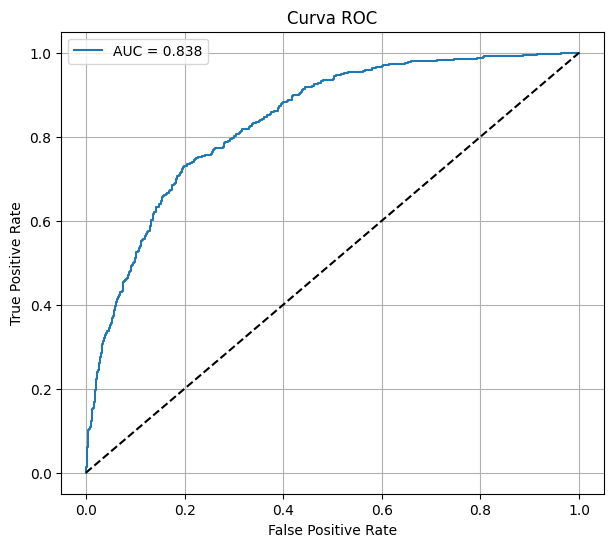

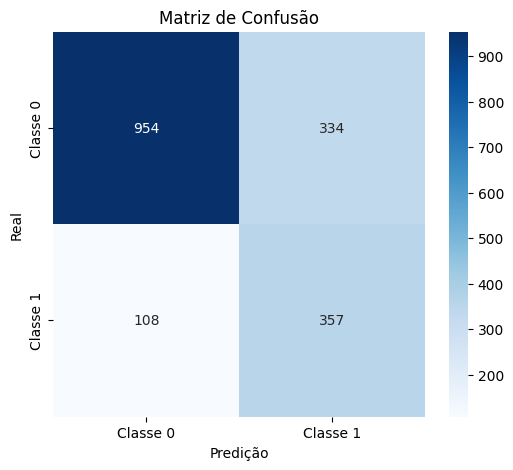

{'ks': np.float64(0.5332014292392975), 'auc': np.float64(0.8380351299004877), 'threshold': 0.5}


In [ ]:
model.eval()
probs, labels = [], []

with torch.no_grad():
    for x_cat, x_cont, y in test_loader:
        x_cat, x_cont = x_cat.to(device), x_cont.to(device)

        logits = model(x_cat, x_cont)
        p = torch.softmax(logits, dim=1)[:, 1]

        probs.extend(p.cpu().numpy())
        labels.extend(y.numpy())

y_prob = np.array(probs)
y_true = np.array(labels)

metrics = plot_model_diagnostics(
    y_true=y_true,
    y_score=y_prob,
    threshold=0.5,
    title_prefix="TabKANet – Teste"
)

print(metrics)

# Experimento 3 - Fixação em hiperparâmetros

## Experimento 3.1 - Embedding Dimension

[I 2025-12-18 18:41:53,324] A new study created in memory with name: no-name-38d6f55a-bb62-474d-938b-adc4ee5bdc76
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
[I 2025-12-18 18:41:57,357] Trial 0 finished with value: 0.5442546583850931 and parameters: {'embedding_dim': 16, 'nhead': 8, 'num_layers': 3, 'dim_feedforward': 64, 'mlp_hidden': 128, 'lr': 0.00020415646286625586, 'weight_decay': 1.0141723812397651e-05, 'batch_size': 512}. Best is trial 0 with value: 0.5442546583850931.
[I 2025-12-18 18:42:02,750] Trial 1 finished with value: 0.5675465838509317 and parameters: {'embedding_dim': 16, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 64, 'mlp_hidden': 128, 'lr': 0.00045463888010342893, 'weight_decay': 1.7169520951608953e-05, 'batch_size': 256}. Best is trial 1 with value: 0.5675465838509317.
[I 2025-12-18 18:42:08,32

Melhor KS: 0.5675465838509317
Melhores hiperparâmetros:
embedding_dim: 16
nhead: 4
num_layers: 2
dim_feedforward: 64
mlp_hidden: 128
lr: 0.00045463888010342893
weight_decay: 1.7169520951608953e-05
batch_size: 256
Epoch 1/30 | Train Loss: 0.5353 | Val Loss: 0.4864 | Val KS: 0.5388
Epoch 2/30 | Train Loss: 0.4959 | Val Loss: 0.4714 | Val KS: 0.5551
Epoch 3/30 | Train Loss: 0.4837 | Val Loss: 0.4570 | Val KS: 0.5722
Epoch 4/30 | Train Loss: 0.4823 | Val Loss: 0.4517 | Val KS: 0.5776
Epoch 5/30 | Train Loss: 0.4743 | Val Loss: 0.4518 | Val KS: 0.5753
Epoch 6/30 | Train Loss: 0.4697 | Val Loss: 0.4556 | Val KS: 0.6064
Epoch 7/30 | Train Loss: 0.4656 | Val Loss: 0.4505 | Val KS: 0.6134
Epoch 8/30 | Train Loss: 0.4597 | Val Loss: 0.4415 | Val KS: 0.5963
Epoch 9/30 | Train Loss: 0.4615 | Val Loss: 0.4307 | Val KS: 0.6203
Epoch 10/30 | Train Loss: 0.4580 | Val Loss: 0.4562 | Val KS: 0.6056
Epoch 11/30 | Train Loss: 0.4493 | Val Loss: 0.4347 | Val KS: 0.6320
Epoch 12/30 | Train Loss: 0.4455 | Va

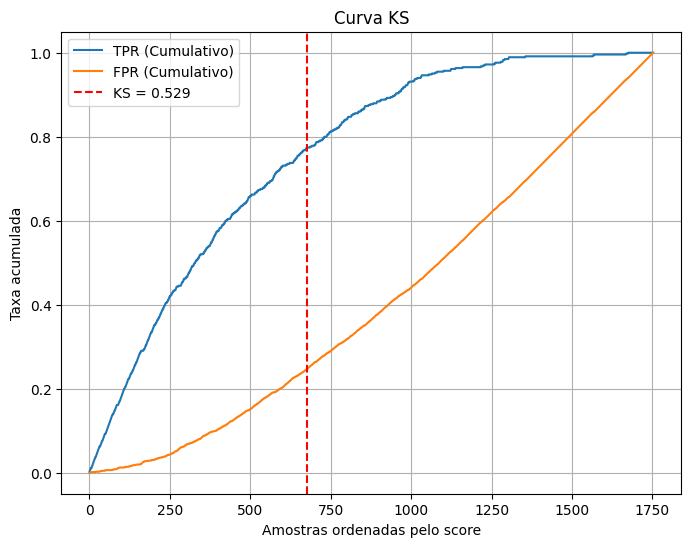

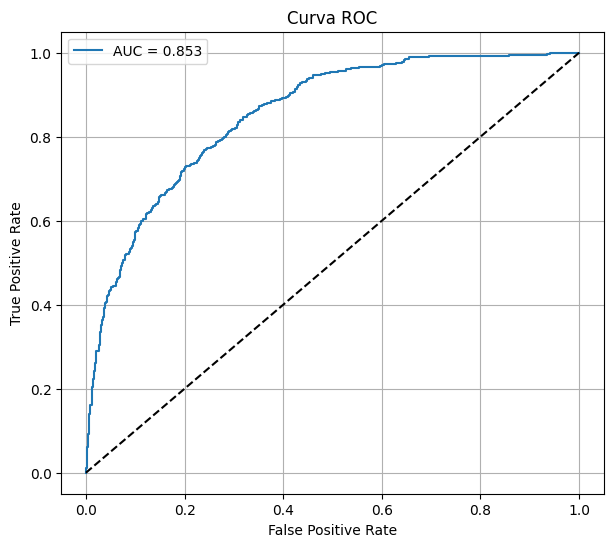

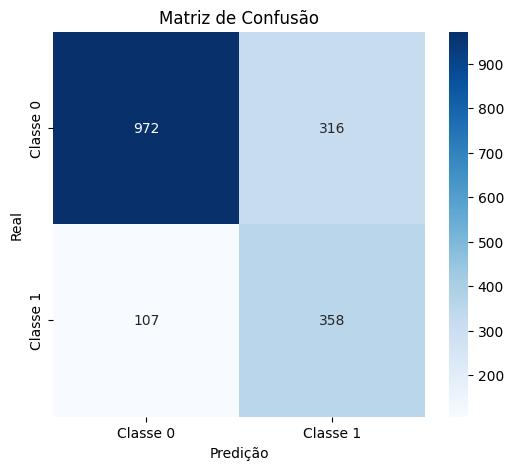

[I 2025-12-18 18:44:14,084] A new study created in memory with name: no-name-6c0298f7-2157-4d31-9d6a-10f31cc443a1


{'ks': np.float64(0.5288519334802645), 'auc': np.float64(0.8527983704000535), 'threshold': 0.5}


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
[I 2025-12-18 18:44:20,429] Trial 0 finished with value: 0.5535714285714286 and parameters: {'embedding_dim': 32, 'nhead': 8, 'num_layers': 1, 'dim_feedforward': 256, 'mlp_hidden': 128, 'lr': 0.00024655963552224565, 'weight_decay': 0.0008173826918411398, 'batch_size': 128}. Best is trial 0 with value: 0.5535714285714286.
[I 2025-12-18 18:44:26,491] Trial 1 finished with value: 0.5512422360248447 and parameters: {'embedding_dim': 32, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 64, 'mlp_hidden': 128, 'lr': 0.0005042774287398174, 'weight_decay': 0.0007147425776915643, 'batch_size': 128}. Best is trial 0 with value: 0.5535714285714286.
[I 2025-12-18 18:44:33,518] Trial 2 finished with value: 0.5659937888198758 and parameters: {'embedding_dim': 32, 'nhead': 4, 'num_layers': 2

Melhor KS: 0.5659937888198758
Melhores hiperparâmetros:
embedding_dim: 32
nhead: 4
num_layers: 2
dim_feedforward: 128
mlp_hidden: 32
lr: 0.0024176121174768984
weight_decay: 0.00010204576192340774
batch_size: 128
Epoch 1/30 | Train Loss: 0.5355 | Val Loss: 0.4658 | Val KS: 0.5637
Epoch 2/30 | Train Loss: 0.4932 | Val Loss: 0.4706 | Val KS: 0.5707
Epoch 3/30 | Train Loss: 0.4868 | Val Loss: 0.4778 | Val KS: 0.5652
Epoch 4/30 | Train Loss: 0.4833 | Val Loss: 0.4567 | Val KS: 0.5776
Epoch 5/30 | Train Loss: 0.4808 | Val Loss: 0.4745 | Val KS: 0.5870
Epoch 6/30 | Train Loss: 0.4747 | Val Loss: 0.4635 | Val KS: 0.6040
Epoch 7/30 | Train Loss: 0.4696 | Val Loss: 0.4693 | Val KS: 0.5901
Epoch 8/30 | Train Loss: 0.4673 | Val Loss: 0.4451 | Val KS: 0.5994
Epoch 9/30 | Train Loss: 0.4640 | Val Loss: 0.4479 | Val KS: 0.6002
Epoch 10/30 | Train Loss: 0.4645 | Val Loss: 0.4695 | Val KS: 0.5939
Epoch 11/30 | Train Loss: 0.4537 | Val Loss: 0.4257 | Val KS: 0.6211
Epoch 12/30 | Train Loss: 0.4511 | Val

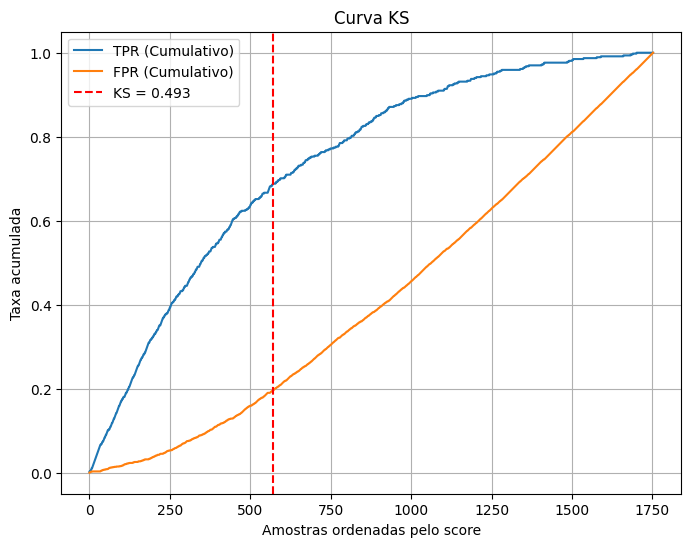

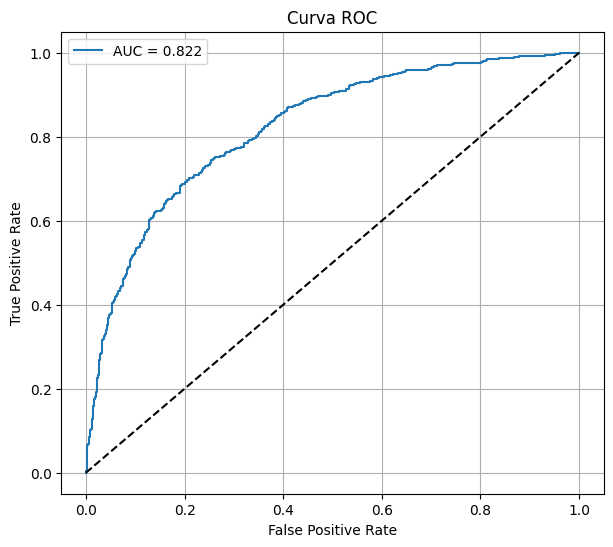

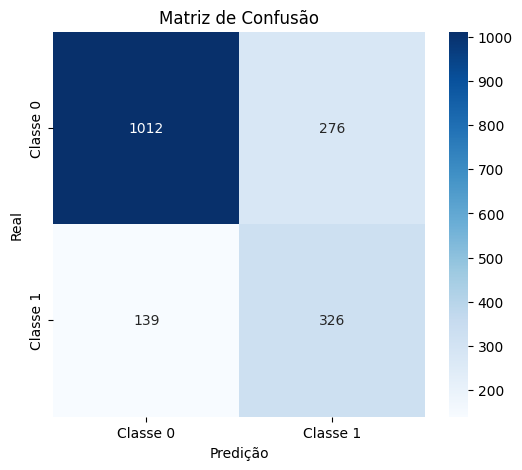

[I 2025-12-18 18:46:47,153] A new study created in memory with name: no-name-ff384ffa-bad2-485e-ae38-e393c7ef6a1c


{'ks': np.float64(0.4932962666132372), 'auc': np.float64(0.8218860615775061), 'threshold': 0.5}


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
[I 2025-12-18 18:46:53,358] Trial 0 finished with value: 0.5582298136645962 and parameters: {'embedding_dim': 64, 'nhead': 8, 'num_layers': 2, 'dim_feedforward': 64, 'mlp_hidden': 64, 'lr': 0.0010516920482456042, 'weight_decay': 0.0006910304194453326, 'batch_size': 128}. Best is trial 0 with value: 0.5582298136645962.
[I 2025-12-18 18:46:57,795] Trial 1 finished with value: 0.531832298136646 and parameters: {'embedding_dim': 64, 'nhead': 2, 'num_layers': 3, 'dim_feedforward': 64, 'mlp_hidden': 32, 'lr': 0.0006770080223362745, 'weight_decay': 2.1191386887139322e-06, 'batch_size': 256}. Best is trial 0 with value: 0.5582298136645962.
[I 2025-12-18 18:47:03,302] Trial 2 finished with value: 0.532608695652174 and parameters: {'embedding_dim': 64, 'nhead': 2, 'num_layers': 1, 'di

Melhor KS: 0.5652173913043478
Melhores hiperparâmetros:
embedding_dim: 64
nhead: 2
num_layers: 3
dim_feedforward: 64
mlp_hidden: 32
lr: 0.0027342255471793035
weight_decay: 0.00023609300857414036
batch_size: 256
Epoch 1/30 | Train Loss: 0.5229 | Val Loss: 0.4735 | Val KS: 0.5629
Epoch 2/30 | Train Loss: 0.4922 | Val Loss: 0.4902 | Val KS: 0.5621
Epoch 3/30 | Train Loss: 0.4852 | Val Loss: 0.4603 | Val KS: 0.5823
Epoch 4/30 | Train Loss: 0.4822 | Val Loss: 0.4621 | Val KS: 0.5823
Epoch 5/30 | Train Loss: 0.4817 | Val Loss: 0.4628 | Val KS: 0.5792
Epoch 6/30 | Train Loss: 0.4685 | Val Loss: 0.4545 | Val KS: 0.6056
Epoch 7/30 | Train Loss: 0.4693 | Val Loss: 0.4491 | Val KS: 0.6165
Epoch 8/30 | Train Loss: 0.4616 | Val Loss: 0.4480 | Val KS: 0.6149
Epoch 9/30 | Train Loss: 0.4598 | Val Loss: 0.4349 | Val KS: 0.6188
Epoch 10/30 | Train Loss: 0.4637 | Val Loss: 0.4405 | Val KS: 0.6118
Epoch 11/30 | Train Loss: 0.4614 | Val Loss: 0.4356 | Val KS: 0.6227
Epoch 12/30 | Train Loss: 0.4512 | Val 

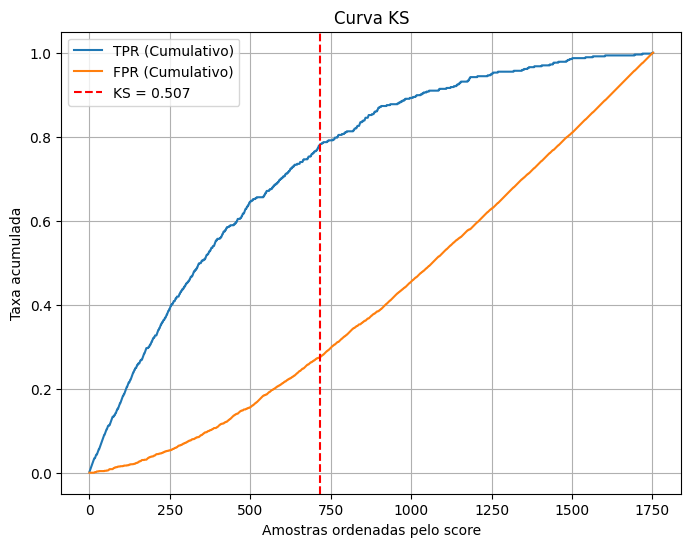

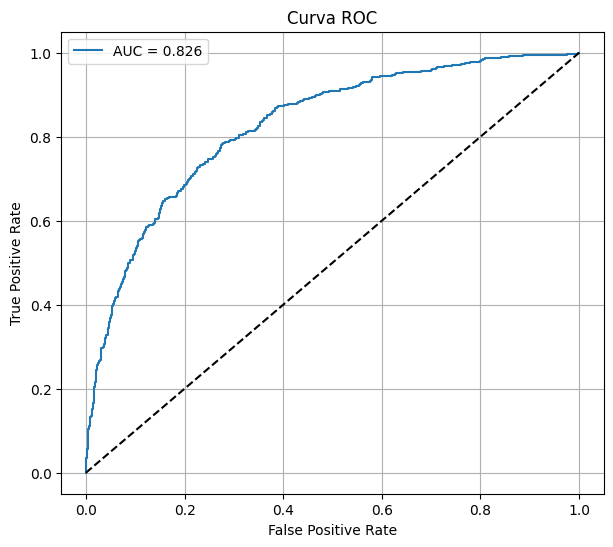

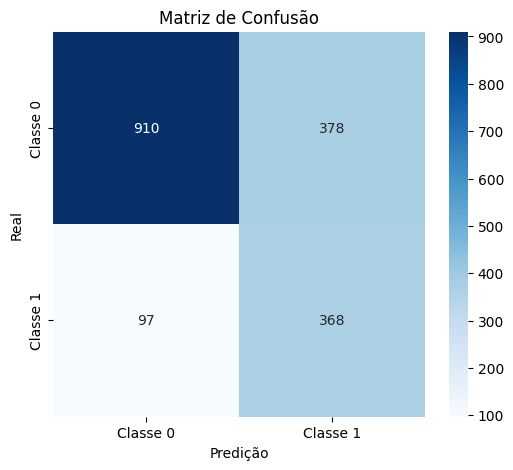

{'ks': np.float64(0.5071745809123089), 'auc': np.float64(0.8260001335737661), 'threshold': 0.5}


In [ ]:
for i in [16, 32, 64]:
    def train_eval_tabkan_1(trial):

        embedding_dim = trial.suggest_categorical("embedding_dim", [i])
        nhead         = trial.suggest_categorical("nhead", [2, 4, 8])
        num_layers    = trial.suggest_int("num_layers", 1, 3)
        dim_ff        = trial.suggest_categorical("dim_feedforward", [64, 128, 256])
        mlp_dim       = trial.suggest_categorical("mlp_hidden", [32, 64, 128])

        lr            = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
        weight_decay  = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
        batch_size    = trial.suggest_categorical("batch_size", [128, 256, 512])

        # loaders dinâmicos
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_ds, batch_size=512)

        model = TabKANet(
            output_dim=2,
            vocabulary=vocab,
            num_continuous_features=Xtr_cont.shape[1],
            embedding_dim=embedding_dim,
            nhead=nhead,
            num_layers=num_layers,
            dim_feedforward=dim_ff,
            mlp_hidden_dims=[mlp_dim],
            activation="gelu",
            attn_dropout_rate=0.1,
            ffn_dropout_rate=0.1,
            learninable_noise=True,
            bins=bins
        ).to(device)

        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay
        )

        criterion = nn.CrossEntropyLoss()

        # treino curto (anti-overfit do Optuna)
        for _ in range(7):
            model.train()
            for x_cat, x_cont, y in train_loader:
                x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)
                optimizer.zero_grad()
                loss = criterion(model(x_cat, x_cont), y)
                loss.backward()
                optimizer.step()

        # validação
        model.eval()
        probs, labels = [], []

        with torch.no_grad():
            for x_cat, x_cont, y in val_loader:
                x_cat, x_cont = x_cat.to(device), x_cont.to(device)
                p = torch.softmax(model(x_cat, x_cont), dim=1)[:, 1]
                probs.extend(p.cpu().numpy())
                labels.extend(y.numpy())

        ks, _ = ks_2samp(
            np.array(probs)[np.array(labels) == 1],
            np.array(probs)[np.array(labels) == 0]
        )

        results_optuna.append({
            "embedding_dim": embedding_dim,
            "nhead": nhead,
            "num_layers": num_layers,
            "dim_feedforward": dim_ff,
            "mlp_hidden": mlp_dim,
            "lr": lr,
            "weight_decay": weight_decay,
            "batch_size": batch_size,
            "ks": ks
        })


        return ks

    results_optuna = []

    study = optuna.create_study(direction="maximize")
    study.optimize(train_eval_tabkan_1, n_trials=20)

    df_optuna = pd.DataFrame(results_optuna)
    df_optuna.sort_values("ks", ascending=False).head(10)

    print("Melhor KS:", study.best_value)
    print("Melhores hiperparâmetros:")
    for k, v in study.best_params.items():
        print(f"{k}: {v}")

    best_params = study.best_params

    trainval_ds = ConcatDataset([train_ds, val_ds])

    trainval_loader = DataLoader(
        trainval_ds,
        batch_size=best_params["batch_size"],
        shuffle=True
    )

    test_loader = DataLoader(test_ds, batch_size=512)

    # ─── Modelo ────────────────────────────────────────────────
    model = TabKANet(
        output_dim=2,
        vocabulary=vocab,
        num_continuous_features=Xtr_cont.shape[1],
        embedding_dim=best_params["embedding_dim"],
        nhead=best_params["nhead"],
        num_layers=best_params["num_layers"],
        dim_feedforward=best_params["dim_feedforward"],
        mlp_hidden_dims=[best_params["mlp_hidden"]],
        activation="gelu",
        attn_dropout_rate=0.1,
        ffn_dropout_rate=0.1,
        learninable_noise=True,
        bins=bins
    ).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=best_params["lr"],
        weight_decay=best_params["weight_decay"]
    )

    criterion = nn.CrossEntropyLoss()

    # ─── Early Stopping ────────────────────────────────────────
    PATIENCE = 5
    best_val_loss = float("inf")
    best_state = None
    epochs_no_improve = 0

    EPOCHS = 30

    history = {
        "train_loss": [],
        "val_loss": [],
        "val_ks": []
    }

    # ─── Loop de Treino ────────────────────────────────────────
    for epoch in range(EPOCHS):

        # ─── Treino ───────────────────────────────────────────
        model.train()
        train_loss = 0.0

        for x_cat, x_cont, y in trainval_loader:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(x_cat, x_cont)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(trainval_loader)

        # ─── Validação (LOSS + KS) ─────────────────────────────
        model.eval()
        val_loss = 0.0
        probs, labels = [], []

        with torch.no_grad():
            for x_cat, x_cont, y in val_loader:
                x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)

                logits = model(x_cat, x_cont)
                loss = criterion(logits, y)
                val_loss += loss.item()

                p = torch.softmax(logits, dim=1)[:, 1]
                probs.extend(p.cpu().numpy())
                labels.extend(y.cpu().numpy())

        val_loss /= len(val_loader)

        # KS apenas como métrica
        val_ks = ks_2samp(
            np.array(probs)[np.array(labels) == 1],
            np.array(probs)[np.array(labels) == 0]
        )[0]

        print(
            f"Epoch {epoch+1}/{EPOCHS} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | "
            f"Val KS: {val_ks:.4f}"
        )

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_ks"].append(val_ks)

        # ─── Early Stopping (baseado no ERRO) ──────────────────
        if val_loss < best_val_loss - 1e-4:  # tolerância numérica
            best_val_loss = val_loss
            best_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping ativado na epoch {epoch+1}")
            break

    # ─── Restaurar melhor modelo ──────────────────────────────
    model.load_state_dict(best_state)

    model.eval()
    probs, labels = [], []

    with torch.no_grad():
        for x_cat, x_cont, y in test_loader:
            x_cat, x_cont = x_cat.to(device), x_cont.to(device)

            logits = model(x_cat, x_cont)
            p = torch.softmax(logits, dim=1)[:, 1]

            probs.extend(p.cpu().numpy())
            labels.extend(y.numpy())

    y_prob = np.array(probs)
    y_true = np.array(labels)

    print(f"\nEmbedding dimension: {i}\n")
    metrics = plot_model_diagnostics(
        y_true=y_true,
        y_score=y_prob,
        threshold=0.5,
        title_prefix="TabKANet – Teste"
    )

    print(metrics)

## Experimento 3.2 - Num Layers

[I 2025-12-18 18:50:25,660] A new study created in memory with name: no-name-f1b5c9d7-df21-41d2-bf57-f0913a1317d7
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
[I 2025-12-18 18:50:35,236] Trial 0 finished with value: 0.5496894409937888 and parameters: {'embedding_dim': 64, 'nhead': 2, 'num_layers': 1, 'dim_feedforward': 256, 'mlp_hidden': 32, 'lr': 0.0009754029756586063, 'weight_decay': 2.055283730731589e-06, 'batch_size': 128}. Best is trial 0 with value: 0.5496894409937888.
[I 2025-12-18 18:50:46,544] Trial 1 finished with value: 0.547360248447205 and parameters: {'embedding_dim': 32, 'nhead': 4, 'num_layers': 1, 'dim_feedforward': 64, 'mlp_hidden': 32, 'lr': 0.0030570810473756183, 'weight_decay': 1.027038192106414e-05, 'batch_size': 128}. Best is trial 0 with value: 0.5496894409937888.
[I 2025-12-18 18:50:52,096] Tri

Melhor KS: 0.5652173913043478
Melhores hiperparâmetros:
embedding_dim: 32
nhead: 2
num_layers: 1
dim_feedforward: 64
mlp_hidden: 128
lr: 0.002476626040822369
weight_decay: 0.0002392228886386878
batch_size: 256
Epoch 1/30 | Train Loss: 0.5477 | Val Loss: 0.4827 | Val KS: 0.5373
Epoch 2/30 | Train Loss: 0.4878 | Val Loss: 0.4628 | Val KS: 0.5668
Epoch 3/30 | Train Loss: 0.4834 | Val Loss: 0.4624 | Val KS: 0.5769
Epoch 4/30 | Train Loss: 0.4813 | Val Loss: 0.4552 | Val KS: 0.5839
Epoch 5/30 | Train Loss: 0.4805 | Val Loss: 0.4602 | Val KS: 0.5807
Epoch 6/30 | Train Loss: 0.4755 | Val Loss: 0.4555 | Val KS: 0.5970
Epoch 7/30 | Train Loss: 0.4750 | Val Loss: 0.4581 | Val KS: 0.5877
Epoch 8/30 | Train Loss: 0.4725 | Val Loss: 0.4580 | Val KS: 0.5986
Epoch 9/30 | Train Loss: 0.4717 | Val Loss: 0.4475 | Val KS: 0.6165
Epoch 10/30 | Train Loss: 0.4677 | Val Loss: 0.4447 | Val KS: 0.6009
Epoch 11/30 | Train Loss: 0.4577 | Val Loss: 0.4544 | Val KS: 0.6196
Epoch 12/30 | Train Loss: 0.4552 | Val L

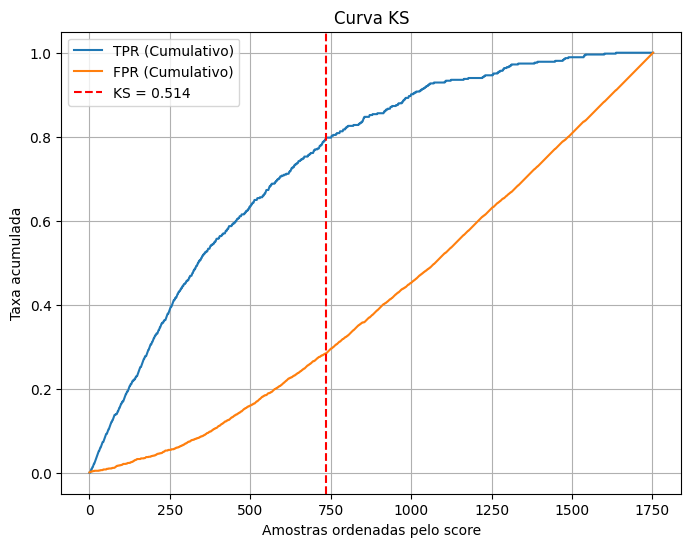

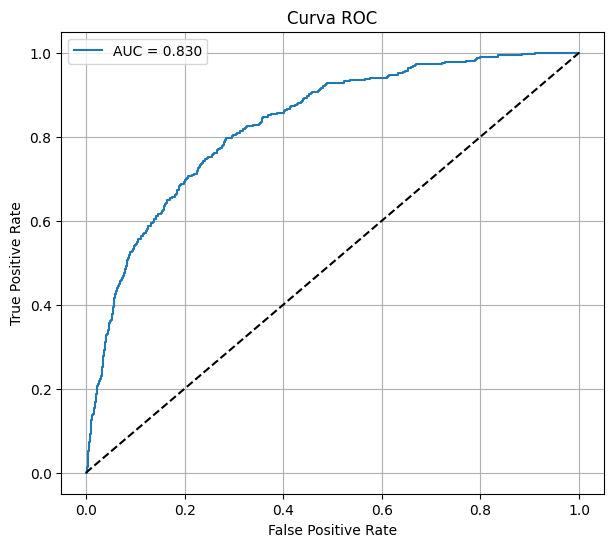

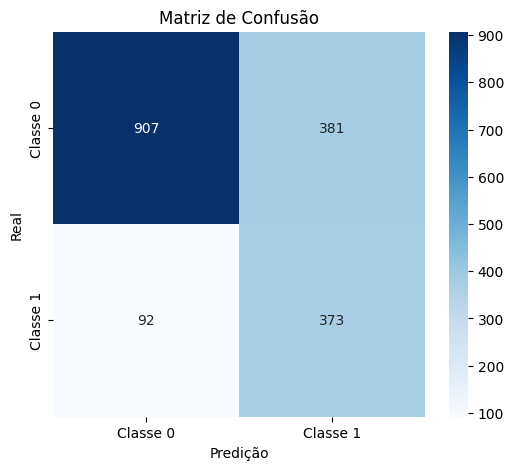

[I 2025-12-18 18:51:37,652] A new study created in memory with name: no-name-62cb68e7-e182-4e00-8750-ebad8eea0bc9


{'ks': np.float64(0.5136879716823616), 'auc': np.float64(0.8296583850931678), 'threshold': 0.5}


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
[I 2025-12-18 18:51:41,001] Trial 0 finished with value: 0.531055900621118 and parameters: {'embedding_dim': 32, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 128, 'mlp_hidden': 32, 'lr': 0.00014612839576296443, 'weight_decay': 0.0002100884065795167, 'batch_size': 256}. Best is trial 0 with value: 0.531055900621118.
[I 2025-12-18 18:51:42,970] Trial 1 finished with value: 0.5380434782608695 and parameters: {'embedding_dim': 16, 'nhead': 2, 'num_layers': 2, 'dim_feedforward': 128, 'mlp_hidden': 32, 'lr': 0.0001943569963112778, 'weight_decay': 2.173541545254219e-06, 'batch_size': 512}. Best is trial 1 with value: 0.5380434782608695.
[I 2025-12-18 18:51:46,322] Trial 2 finished with value: 0.5512422360248447 and parameters: {'embedding_dim': 64, 'nhead': 2, 'num_layers': 2, '

Melhor KS: 0.5512422360248447
Melhores hiperparâmetros:
embedding_dim: 64
nhead: 2
num_layers: 2
dim_feedforward: 64
mlp_hidden: 32
lr: 0.0027448288164042493
weight_decay: 0.00011665588765516533
batch_size: 256
Epoch 1/30 | Train Loss: 0.5409 | Val Loss: 0.4783 | Val KS: 0.5435
Epoch 2/30 | Train Loss: 0.4959 | Val Loss: 0.4691 | Val KS: 0.5613
Epoch 3/30 | Train Loss: 0.4823 | Val Loss: 0.4761 | Val KS: 0.5784
Epoch 4/30 | Train Loss: 0.4839 | Val Loss: 0.4693 | Val KS: 0.5745
Epoch 5/30 | Train Loss: 0.4768 | Val Loss: 0.4677 | Val KS: 0.5862
Epoch 6/30 | Train Loss: 0.4772 | Val Loss: 0.4487 | Val KS: 0.5877
Epoch 7/30 | Train Loss: 0.4738 | Val Loss: 0.4563 | Val KS: 0.5831
Epoch 8/30 | Train Loss: 0.4704 | Val Loss: 0.4403 | Val KS: 0.5963
Epoch 9/30 | Train Loss: 0.4619 | Val Loss: 0.4486 | Val KS: 0.6071
Epoch 10/30 | Train Loss: 0.4686 | Val Loss: 0.4488 | Val KS: 0.6071
Epoch 11/30 | Train Loss: 0.4597 | Val Loss: 0.4152 | Val KS: 0.6281
Epoch 12/30 | Train Loss: 0.4553 | Val 

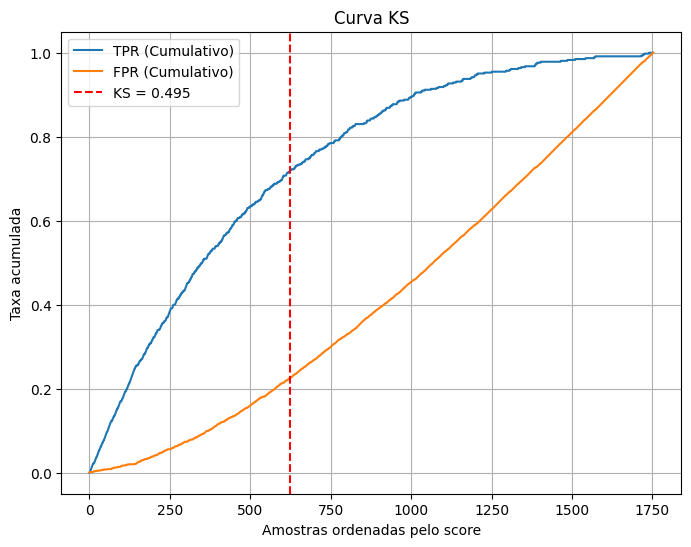

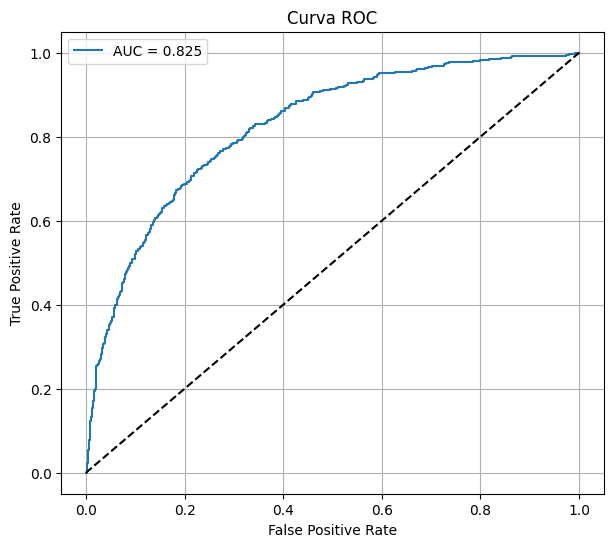

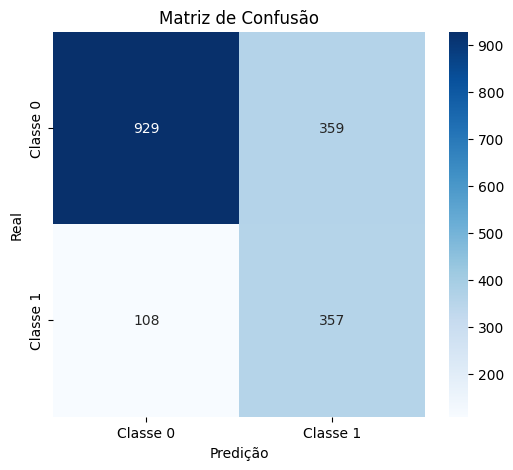

[I 2025-12-18 18:52:50,633] A new study created in memory with name: no-name-362be4f7-f55c-4382-a47d-fa0094340e16


{'ks': np.float64(0.49527482802377615), 'auc': np.float64(0.8245341614906833), 'threshold': 0.5}


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
[I 2025-12-18 18:52:53,324] Trial 0 finished with value: 0.5458074534161491 and parameters: {'embedding_dim': 32, 'nhead': 8, 'num_layers': 3, 'dim_feedforward': 128, 'mlp_hidden': 64, 'lr': 0.003747013793749566, 'weight_decay': 1.2091091713305206e-05, 'batch_size': 512}. Best is trial 0 with value: 0.5458074534161491.
[I 2025-12-18 18:53:01,208] Trial 1 finished with value: 0.531832298136646 and parameters: {'embedding_dim': 64, 'nhead': 4, 'num_layers': 3, 'dim_feedforward': 256, 'mlp_hidden': 128, 'lr': 0.0034000680257843083, 'weight_decay': 2.9600785336632613e-06, 'batch_size': 128}. Best is trial 0 with value: 0.5458074534161491.
[I 2025-12-18 18:53:03,524] Trial 2 finished with value: 0.5458074534161491 and parameters: {'embedding_dim': 16, 'nhead': 2, 'num_layers': 3,

Melhor KS: 0.5590062111801242
Melhores hiperparâmetros:
embedding_dim: 64
nhead: 2
num_layers: 3
dim_feedforward: 128
mlp_hidden: 64
lr: 0.0001289560926569336
weight_decay: 6.793914031242969e-05
batch_size: 128
Epoch 1/30 | Train Loss: 0.5288 | Val Loss: 0.4944 | Val KS: 0.5396
Epoch 2/30 | Train Loss: 0.4945 | Val Loss: 0.4758 | Val KS: 0.5621
Epoch 3/30 | Train Loss: 0.4849 | Val Loss: 0.4822 | Val KS: 0.5660
Epoch 4/30 | Train Loss: 0.4787 | Val Loss: 0.4610 | Val KS: 0.5792
Epoch 5/30 | Train Loss: 0.4752 | Val Loss: 0.4455 | Val KS: 0.5924
Epoch 6/30 | Train Loss: 0.4700 | Val Loss: 0.4489 | Val KS: 0.5970
Epoch 7/30 | Train Loss: 0.4661 | Val Loss: 0.4457 | Val KS: 0.6017
Epoch 8/30 | Train Loss: 0.4645 | Val Loss: 0.4735 | Val KS: 0.6087
Epoch 9/30 | Train Loss: 0.4591 | Val Loss: 0.4454 | Val KS: 0.6165
Epoch 10/30 | Train Loss: 0.4557 | Val Loss: 0.4434 | Val KS: 0.6048
Epoch 11/30 | Train Loss: 0.4533 | Val Loss: 0.4245 | Val KS: 0.6134
Epoch 12/30 | Train Loss: 0.4528 | Val 

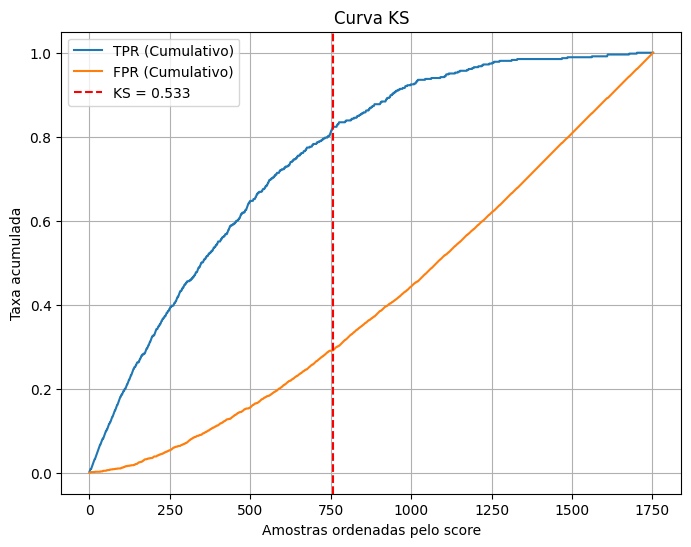

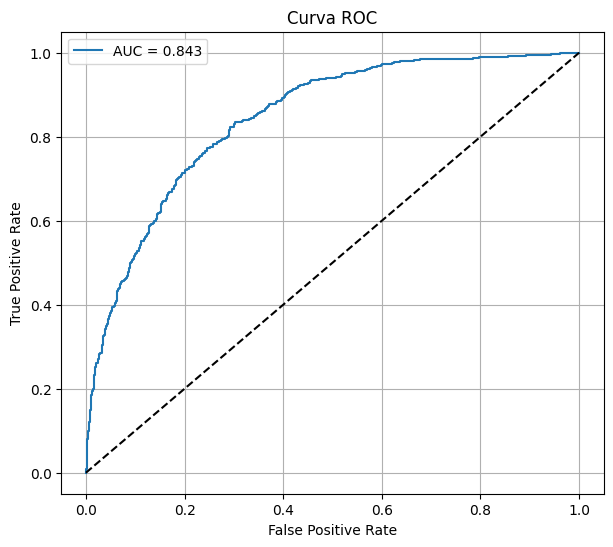

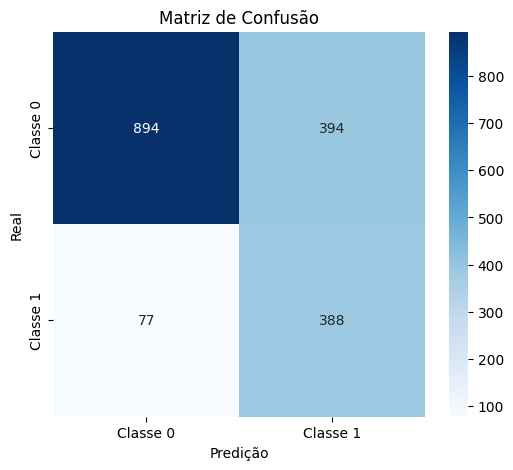

{'ks': np.float64(0.5325068456555132), 'auc': np.float64(0.8433196420223068), 'threshold': 0.5}


In [ ]:
for i in [1, 2, 3]:
    def train_eval_tabkan_1(trial):

        embedding_dim = trial.suggest_categorical("embedding_dim", [16, 32, 64])
        nhead         = trial.suggest_categorical("nhead", [2, 4, 8])
        num_layers    = trial.suggest_int("num_layers", i, i)
        dim_ff        = trial.suggest_categorical("dim_feedforward", [64, 128, 256])
        mlp_dim       = trial.suggest_categorical("mlp_hidden", [32, 64, 128])

        lr            = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
        weight_decay  = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
        batch_size    = trial.suggest_categorical("batch_size", [128, 256, 512])

        # loaders dinâmicos
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_ds, batch_size=512)

        model = TabKANet(
            output_dim=2,
            vocabulary=vocab,
            num_continuous_features=Xtr_cont.shape[1],
            embedding_dim=embedding_dim,
            nhead=nhead,
            num_layers=num_layers,
            dim_feedforward=dim_ff,
            mlp_hidden_dims=[mlp_dim],
            activation="gelu",
            attn_dropout_rate=0.1,
            ffn_dropout_rate=0.1,
            learninable_noise=True,
            bins=bins
        ).to(device)

        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay
        )

        criterion = nn.CrossEntropyLoss()

        # treino curto (anti-overfit do Optuna)
        for _ in range(7):
            model.train()
            for x_cat, x_cont, y in train_loader:
                x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)
                optimizer.zero_grad()
                loss = criterion(model(x_cat, x_cont), y)
                loss.backward()
                optimizer.step()

        # validação
        model.eval()
        probs, labels = [], []

        with torch.no_grad():
            for x_cat, x_cont, y in val_loader:
                x_cat, x_cont = x_cat.to(device), x_cont.to(device)
                p = torch.softmax(model(x_cat, x_cont), dim=1)[:, 1]
                probs.extend(p.cpu().numpy())
                labels.extend(y.numpy())

        ks, _ = ks_2samp(
            np.array(probs)[np.array(labels) == 1],
            np.array(probs)[np.array(labels) == 0]
        )

        results_optuna.append({
            "embedding_dim": embedding_dim,
            "nhead": nhead,
            "num_layers": num_layers,
            "dim_feedforward": dim_ff,
            "mlp_hidden": mlp_dim,
            "lr": lr,
            "weight_decay": weight_decay,
            "batch_size": batch_size,
            "ks": ks
        })


        return ks

    results_optuna = []

    study = optuna.create_study(direction="maximize")
    study.optimize(train_eval_tabkan_1, n_trials=10)

    df_optuna = pd.DataFrame(results_optuna)
    df_optuna.sort_values("ks", ascending=False).head(10)

    print("Melhor KS:", study.best_value)
    print("Melhores hiperparâmetros:")
    for k, v in study.best_params.items():
        print(f"{k}: {v}")

    best_params = study.best_params

    trainval_ds = ConcatDataset([train_ds, val_ds])

    trainval_loader = DataLoader(
        trainval_ds,
        batch_size=best_params["batch_size"],
        shuffle=True
    )

    test_loader = DataLoader(test_ds, batch_size=512)

    # ─── Modelo ────────────────────────────────────────────────
    model = TabKANet(
        output_dim=2,
        vocabulary=vocab,
        num_continuous_features=Xtr_cont.shape[1],
        embedding_dim=best_params["embedding_dim"],
        nhead=best_params["nhead"],
        num_layers=best_params["num_layers"],
        dim_feedforward=best_params["dim_feedforward"],
        mlp_hidden_dims=[best_params["mlp_hidden"]],
        activation="gelu",
        attn_dropout_rate=0.1,
        ffn_dropout_rate=0.1,
        learninable_noise=True,
        bins=bins
    ).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=best_params["lr"],
        weight_decay=best_params["weight_decay"]
    )

    criterion = nn.CrossEntropyLoss()

    # ─── Early Stopping ────────────────────────────────────────
    PATIENCE = 5
    best_val_loss = float("inf")
    best_state = None
    epochs_no_improve = 0

    EPOCHS = 30

    history = {
        "train_loss": [],
        "val_loss": [],
        "val_ks": []
    }

    # ─── Loop de Treino ────────────────────────────────────────
    for epoch in range(EPOCHS):

        # ─── Treino ───────────────────────────────────────────
        model.train()
        train_loss = 0.0

        for x_cat, x_cont, y in trainval_loader:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(x_cat, x_cont)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(trainval_loader)

        # ─── Validação (LOSS + KS) ─────────────────────────────
        model.eval()
        val_loss = 0.0
        probs, labels = [], []

        with torch.no_grad():
            for x_cat, x_cont, y in val_loader:
                x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)

                logits = model(x_cat, x_cont)
                loss = criterion(logits, y)
                val_loss += loss.item()

                p = torch.softmax(logits, dim=1)[:, 1]
                probs.extend(p.cpu().numpy())
                labels.extend(y.cpu().numpy())

        val_loss /= len(val_loader)

        # KS apenas como métrica
        val_ks = ks_2samp(
            np.array(probs)[np.array(labels) == 1],
            np.array(probs)[np.array(labels) == 0]
        )[0]

        print(
            f"Epoch {epoch+1}/{EPOCHS} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | "
            f"Val KS: {val_ks:.4f}"
        )

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_ks"].append(val_ks)

        # ─── Early Stopping (baseado no ERRO) ──────────────────
        if val_loss < best_val_loss - 1e-4:  # tolerância numérica
            best_val_loss = val_loss
            best_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping ativado na epoch {epoch+1}")
            break

    # ─── Restaurar melhor modelo ──────────────────────────────
    model.load_state_dict(best_state)

    model.eval()
    probs, labels = [], []

    with torch.no_grad():
        for x_cat, x_cont, y in test_loader:
            x_cat, x_cont = x_cat.to(device), x_cont.to(device)

            logits = model(x_cat, x_cont)
            p = torch.softmax(logits, dim=1)[:, 1]

            probs.extend(p.cpu().numpy())
            labels.extend(y.numpy())

    y_prob = np.array(probs)
    y_true = np.array(labels)

    print(f"\nEmbedding dimension: {i}\n")
    metrics = plot_model_diagnostics(
        y_true=y_true,
        y_score=y_prob,
        threshold=0.5,
        title_prefix="TabKANet – Teste"
    )

    print(metrics)

## Experimento 3.3 - Nhead

[I 2025-12-18 18:55:21,530] A new study created in memory with name: no-name-e47b8059-aba1-43d4-8044-003d4a171be7
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
[I 2025-12-18 18:55:24,604] Trial 0 finished with value: 0.5364906832298136 and parameters: {'embedding_dim': 16, 'nhead': 2, 'num_layers': 2, 'dim_feedforward': 256, 'mlp_hidden': 64, 'lr': 0.0001306822582443441, 'weight_decay': 0.00030971110578891284, 'batch_size': 512}. Best is trial 0 with value: 0.5364906832298136.
[I 2025-12-18 18:55:28,054] Trial 1 finished with value: 0.5543478260869565 and parameters: {'embedding_dim': 64, 'nhead': 2, 'num_layers': 2, 'dim_feedforward': 256, 'mlp_hidden': 128, 'lr': 0.0007036715030275476, 'weight_decay': 0.0005995068801175476, 'batch_size': 256}. Best is trial 1 with value: 0.5543478260869565.
[I 2025-12-18 18:55:39,492]

Melhor KS: 0.5799689440993789
Melhores hiperparâmetros:
embedding_dim: 32
nhead: 2
num_layers: 3
dim_feedforward: 128
mlp_hidden: 32
lr: 0.001958067105341012
weight_decay: 2.4169182416756974e-05
batch_size: 128
Epoch 1/30 | Train Loss: 0.5160 | Val Loss: 0.4901 | Val KS: 0.5598
Epoch 2/30 | Train Loss: 0.4901 | Val Loss: 0.4827 | Val KS: 0.5707
Epoch 3/30 | Train Loss: 0.4853 | Val Loss: 0.4667 | Val KS: 0.5714
Epoch 4/30 | Train Loss: 0.4833 | Val Loss: 0.4784 | Val KS: 0.5815
Epoch 5/30 | Train Loss: 0.4812 | Val Loss: 0.4583 | Val KS: 0.5839
Epoch 6/30 | Train Loss: 0.4714 | Val Loss: 0.4413 | Val KS: 0.5916
Epoch 7/30 | Train Loss: 0.4705 | Val Loss: 0.4561 | Val KS: 0.6102
Epoch 8/30 | Train Loss: 0.4656 | Val Loss: 0.4539 | Val KS: 0.6002
Epoch 9/30 | Train Loss: 0.4595 | Val Loss: 0.4517 | Val KS: 0.5932
Epoch 10/30 | Train Loss: 0.4586 | Val Loss: 0.4798 | Val KS: 0.6017
Epoch 11/30 | Train Loss: 0.4582 | Val Loss: 0.4507 | Val KS: 0.6102
Early stopping ativado na epoch 11

Par

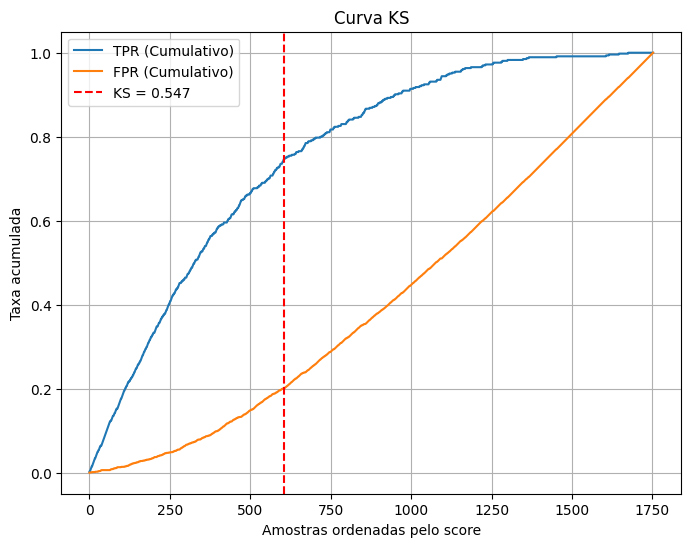

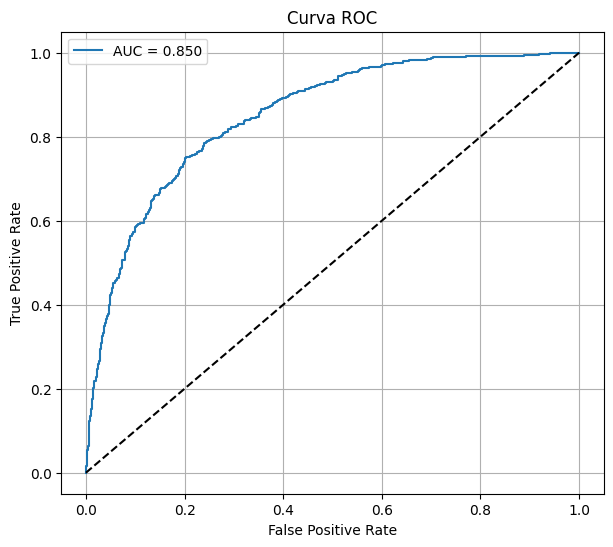

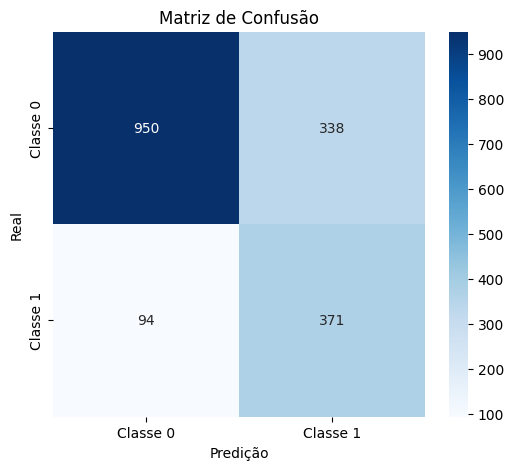

[I 2025-12-18 18:57:34,222] A new study created in memory with name: no-name-b4797ca9-e0a6-420c-865f-8686d1cb2680


{'ks': np.float64(0.5473001402524544), 'auc': np.float64(0.8504975622787685), 'threshold': 0.5}


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
[I 2025-12-18 18:57:36,530] Trial 0 finished with value: 0.5403726708074534 and parameters: {'embedding_dim': 32, 'nhead': 4, 'num_layers': 3, 'dim_feedforward': 64, 'mlp_hidden': 32, 'lr': 0.0002120065051609627, 'weight_decay': 3.0573573747226685e-06, 'batch_size': 512}. Best is trial 0 with value: 0.5403726708074534.
[I 2025-12-18 18:57:39,301] Trial 1 finished with value: 0.532608695652174 and parameters: {'embedding_dim': 64, 'nhead': 4, 'num_layers': 3, 'dim_feedforward': 128, 'mlp_hidden': 128, 'lr': 0.0011547038007959896, 'weight_decay': 1.780971164380015e-05, 'batch_size': 512}. Best is trial 0 with value: 0.5403726708074534.
[I 2025-12-18 18:57:42,876] Trial 2 finished with value: 0.5543478260869565 and parameters: {'embedding_dim': 64, 'nhead': 4, 'num_layers': 1, 

Melhor KS: 0.5675465838509317
Melhores hiperparâmetros:
embedding_dim: 32
nhead: 4
num_layers: 2
dim_feedforward: 256
mlp_hidden: 64
lr: 0.004584431510671983
weight_decay: 1.1172696592112172e-06
batch_size: 512
Epoch 1/30 | Train Loss: 0.6229 | Val Loss: 0.4937 | Val KS: 0.5210
Epoch 2/30 | Train Loss: 0.5139 | Val Loss: 0.4819 | Val KS: 0.5621
Epoch 3/30 | Train Loss: 0.5001 | Val Loss: 0.4718 | Val KS: 0.5683
Epoch 4/30 | Train Loss: 0.4894 | Val Loss: 0.4658 | Val KS: 0.5652
Epoch 5/30 | Train Loss: 0.4910 | Val Loss: 0.4648 | Val KS: 0.5753
Epoch 6/30 | Train Loss: 0.4839 | Val Loss: 0.4640 | Val KS: 0.5637
Epoch 7/30 | Train Loss: 0.4790 | Val Loss: 0.4799 | Val KS: 0.5846
Epoch 8/30 | Train Loss: 0.4806 | Val Loss: 0.4520 | Val KS: 0.5823
Epoch 9/30 | Train Loss: 0.4763 | Val Loss: 0.4775 | Val KS: 0.5854
Epoch 10/30 | Train Loss: 0.4775 | Val Loss: 0.4585 | Val KS: 0.5839
Epoch 11/30 | Train Loss: 0.4793 | Val Loss: 0.4451 | Val KS: 0.5831
Epoch 12/30 | Train Loss: 0.4721 | Val 

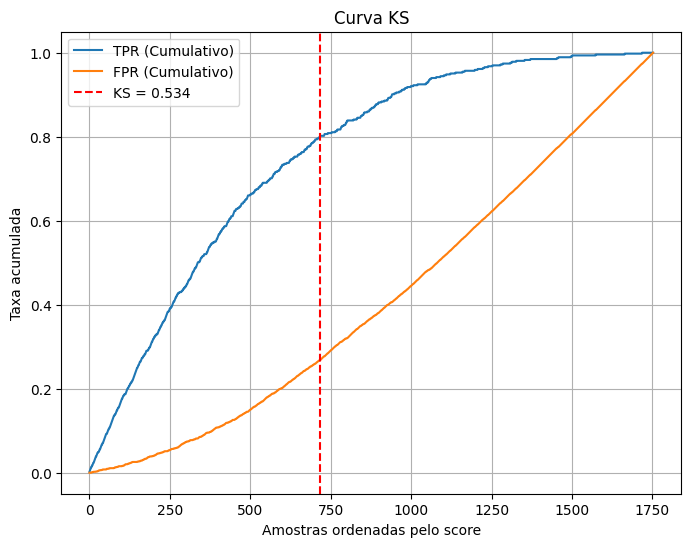

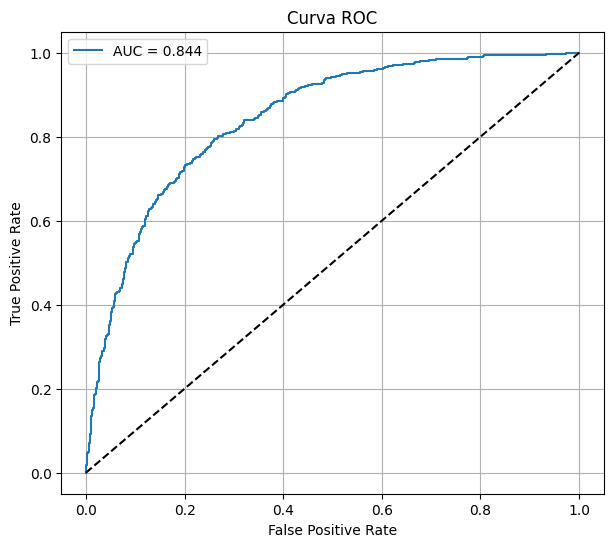

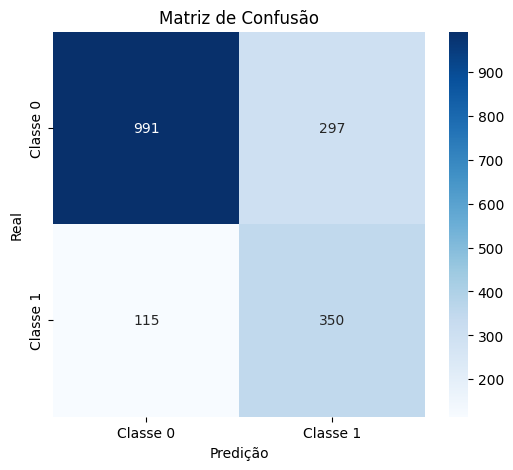

[I 2025-12-18 18:58:59,778] A new study created in memory with name: no-name-5e78b0f9-efec-4fe5-8cad-ba1f84189bd8


{'ks': np.float64(0.5342933947772657), 'auc': np.float64(0.8440125559340147), 'threshold': 0.5}


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
[I 2025-12-18 18:59:01,593] Trial 0 finished with value: 0.5652173913043478 and parameters: {'embedding_dim': 16, 'nhead': 8, 'num_layers': 1, 'dim_feedforward': 128, 'mlp_hidden': 64, 'lr': 0.002111001295523925, 'weight_decay': 6.312355476333286e-05, 'batch_size': 512}. Best is trial 0 with value: 0.5652173913043478.
[I 2025-12-18 18:59:04,888] Trial 1 finished with value: 0.5295031055900621 and parameters: {'embedding_dim': 16, 'nhead': 8, 'num_layers': 2, 'dim_feedforward': 64, 'mlp_hidden': 64, 'lr': 0.00015307801205659895, 'weight_decay': 0.000358178840690642, 'batch_size': 256}. Best is trial 0 with value: 0.5652173913043478.
[I 2025-12-18 18:59:08,193] Trial 2 finished with value: 0.5690993788819876 and parameters: {'embedding_dim': 64, 'nhead': 8, 'num_layers': 2, 'd

Melhor KS: 0.5760869565217391
Melhores hiperparâmetros:
embedding_dim: 32
nhead: 8
num_layers: 2
dim_feedforward: 128
mlp_hidden: 32
lr: 0.0036406240672442877
weight_decay: 5.0817756155138825e-06
batch_size: 256
Epoch 1/30 | Train Loss: 0.5337 | Val Loss: 0.4851 | Val KS: 0.5505
Epoch 2/30 | Train Loss: 0.4953 | Val Loss: 0.4865 | Val KS: 0.5730
Epoch 3/30 | Train Loss: 0.4868 | Val Loss: 0.4797 | Val KS: 0.5691
Epoch 4/30 | Train Loss: 0.4872 | Val Loss: 0.4701 | Val KS: 0.5776
Epoch 5/30 | Train Loss: 0.4844 | Val Loss: 0.4689 | Val KS: 0.5831
Epoch 6/30 | Train Loss: 0.4783 | Val Loss: 0.4694 | Val KS: 0.5846
Epoch 7/30 | Train Loss: 0.4799 | Val Loss: 0.4554 | Val KS: 0.5924
Epoch 8/30 | Train Loss: 0.4761 | Val Loss: 0.4777 | Val KS: 0.5784
Epoch 9/30 | Train Loss: 0.4746 | Val Loss: 0.4580 | Val KS: 0.5823
Epoch 10/30 | Train Loss: 0.4669 | Val Loss: 0.4495 | Val KS: 0.5947
Epoch 11/30 | Train Loss: 0.4662 | Val Loss: 0.4496 | Val KS: 0.6087
Epoch 12/30 | Train Loss: 0.4661 | Val

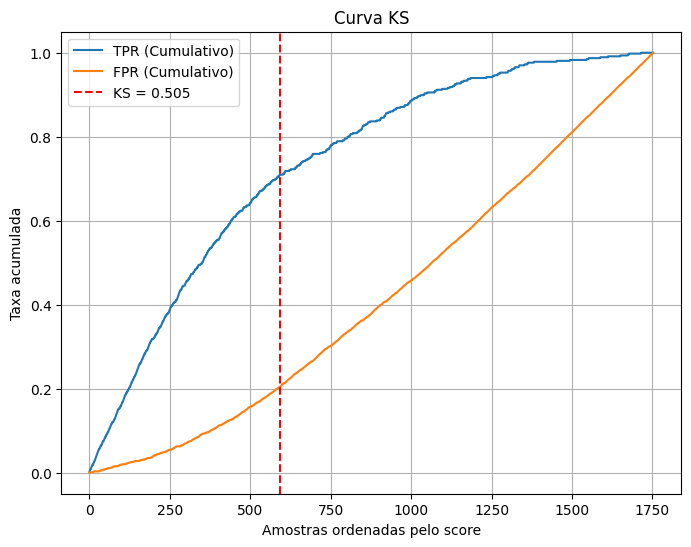

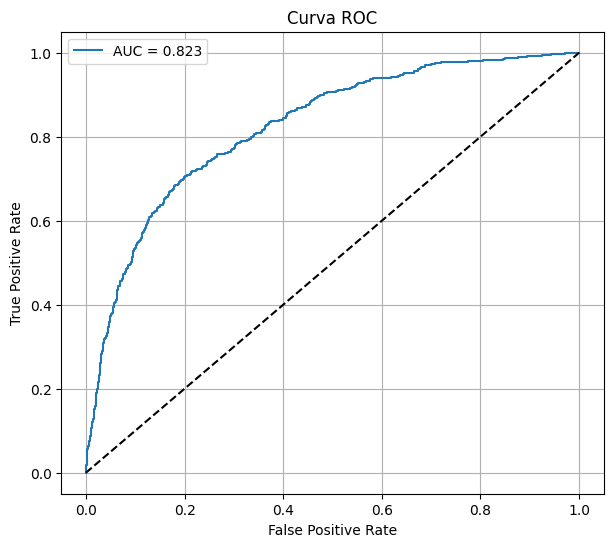

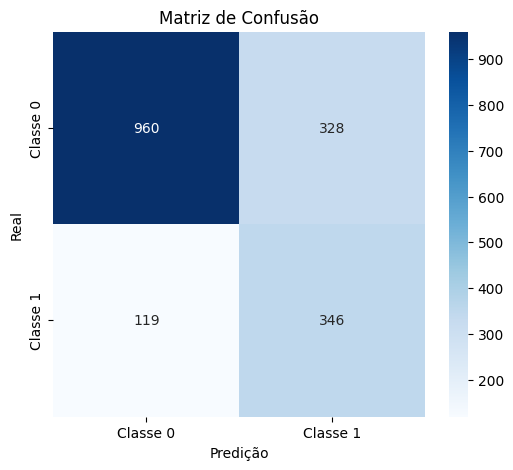

{'ks': np.float64(0.5054848727709877), 'auc': np.float64(0.8230431443264541), 'threshold': 0.5}


In [ ]:
for i in [2, 4, 8]:
    def train_eval_tabkan_1(trial):

        embedding_dim = trial.suggest_categorical("embedding_dim", [16, 32, 64])
        nhead         = trial.suggest_categorical("nhead", [i])
        num_layers    = trial.suggest_int("num_layers", 1, 3)
        dim_ff        = trial.suggest_categorical("dim_feedforward", [64, 128, 256])
        mlp_dim       = trial.suggest_categorical("mlp_hidden", [32, 64, 128])

        lr            = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
        weight_decay  = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
        batch_size    = trial.suggest_categorical("batch_size", [128, 256, 512])

        # loaders dinâmicos
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_ds, batch_size=512)

        model = TabKANet(
            output_dim=2,
            vocabulary=vocab,
            num_continuous_features=Xtr_cont.shape[1],
            embedding_dim=embedding_dim,
            nhead=nhead,
            num_layers=num_layers,
            dim_feedforward=dim_ff,
            mlp_hidden_dims=[mlp_dim],
            activation="gelu",
            attn_dropout_rate=0.1,
            ffn_dropout_rate=0.1,
            learninable_noise=True,
            bins=bins
        ).to(device)

        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay
        )

        criterion = nn.CrossEntropyLoss()

        # treino curto (anti-overfit do Optuna)
        for _ in range(7):
            model.train()
            for x_cat, x_cont, y in train_loader:
                x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)
                optimizer.zero_grad()
                loss = criterion(model(x_cat, x_cont), y)
                loss.backward()
                optimizer.step()

        # validação
        model.eval()
        probs, labels = [], []

        with torch.no_grad():
            for x_cat, x_cont, y in val_loader:
                x_cat, x_cont = x_cat.to(device), x_cont.to(device)
                p = torch.softmax(model(x_cat, x_cont), dim=1)[:, 1]
                probs.extend(p.cpu().numpy())
                labels.extend(y.numpy())

        ks, _ = ks_2samp(
            np.array(probs)[np.array(labels) == 1],
            np.array(probs)[np.array(labels) == 0]
        )

        results_optuna.append({
            "embedding_dim": embedding_dim,
            "nhead": nhead,
            "num_layers": num_layers,
            "dim_feedforward": dim_ff,
            "mlp_hidden": mlp_dim,
            "lr": lr,
            "weight_decay": weight_decay,
            "batch_size": batch_size,
            "ks": ks
        })


        return ks

    results_optuna = []

    study = optuna.create_study(direction="maximize")
    study.optimize(train_eval_tabkan_1, n_trials=20)

    df_optuna = pd.DataFrame(results_optuna)
    df_optuna.sort_values("ks", ascending=False).head(10)

    print("Melhor KS:", study.best_value)
    print("Melhores hiperparâmetros:")
    for k, v in study.best_params.items():
        print(f"{k}: {v}")

    best_params = study.best_params

    trainval_ds = ConcatDataset([train_ds, val_ds])

    trainval_loader = DataLoader(
        trainval_ds,
        batch_size=best_params["batch_size"],
        shuffle=True
    )

    test_loader = DataLoader(test_ds, batch_size=512)

    # ─── Modelo ────────────────────────────────────────────────
    model = TabKANet(
        output_dim=2,
        vocabulary=vocab,
        num_continuous_features=Xtr_cont.shape[1],
        embedding_dim=best_params["embedding_dim"],
        nhead=best_params["nhead"],
        num_layers=best_params["num_layers"],
        dim_feedforward=best_params["dim_feedforward"],
        mlp_hidden_dims=[best_params["mlp_hidden"]],
        activation="gelu",
        attn_dropout_rate=0.1,
        ffn_dropout_rate=0.1,
        learninable_noise=True,
        bins=bins
    ).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=best_params["lr"],
        weight_decay=best_params["weight_decay"]
    )

    criterion = nn.CrossEntropyLoss()

    # ─── Early Stopping ────────────────────────────────────────
    PATIENCE = 5
    best_val_loss = float("inf")
    best_state = None
    epochs_no_improve = 0

    EPOCHS = 30

    history = {
        "train_loss": [],
        "val_loss": [],
        "val_ks": []
    }

    # ─── Loop de Treino ────────────────────────────────────────
    for epoch in range(EPOCHS):

        # ─── Treino ───────────────────────────────────────────
        model.train()
        train_loss = 0.0

        for x_cat, x_cont, y in trainval_loader:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(x_cat, x_cont)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(trainval_loader)

        # ─── Validação (LOSS + KS) ─────────────────────────────
        model.eval()
        val_loss = 0.0
        probs, labels = [], []

        with torch.no_grad():
            for x_cat, x_cont, y in val_loader:
                x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)

                logits = model(x_cat, x_cont)
                loss = criterion(logits, y)
                val_loss += loss.item()

                p = torch.softmax(logits, dim=1)[:, 1]
                probs.extend(p.cpu().numpy())
                labels.extend(y.cpu().numpy())

        val_loss /= len(val_loader)

        # KS apenas como métrica
        val_ks = ks_2samp(
            np.array(probs)[np.array(labels) == 1],
            np.array(probs)[np.array(labels) == 0]
        )[0]

        print(
            f"Epoch {epoch+1}/{EPOCHS} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | "
            f"Val KS: {val_ks:.4f}"
        )

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_ks"].append(val_ks)

        # ─── Early Stopping (baseado no ERRO) ──────────────────
        if val_loss < best_val_loss - 1e-4:  # tolerância numérica
            best_val_loss = val_loss
            best_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping ativado na epoch {epoch+1}")
            break

    # ─── Restaurar melhor modelo ──────────────────────────────
    model.load_state_dict(best_state)

    model.eval()
    probs, labels = [], []

    with torch.no_grad():
        for x_cat, x_cont, y in test_loader:
            x_cat, x_cont = x_cat.to(device), x_cont.to(device)

            logits = model(x_cat, x_cont)
            p = torch.softmax(logits, dim=1)[:, 1]

            probs.extend(p.cpu().numpy())
            labels.extend(y.numpy())

    y_prob = np.array(probs)
    y_true = np.array(labels)

    print(f"\nParameter: {i}\n")
    metrics = plot_model_diagnostics(
        y_true=y_true,
        y_score=y_prob,
        threshold=0.5,
        title_prefix="TabKANet – Teste"
    )

    print(metrics)

## Experimento 3.4 - dim_feedforward e mlp_hidden_dims

[I 2025-12-18 19:03:21,050] A new study created in memory with name: no-name-a89923e7-d33c-4c4d-b379-99675857af3f
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
[I 2025-12-18 19:03:26,176] Trial 0 finished with value: 0.5535714285714286 and parameters: {'embedding_dim': 32, 'nhead': 4, 'num_layers': 3, 'dim_feedforward': 256, 'mlp_hidden': 32, 'lr': 0.0019023478679297736, 'weight_decay': 0.0007179245627231448, 'batch_size': 512}. Best is trial 0 with value: 0.5535714285714286.
[I 2025-12-18 19:03:30,647] Trial 1 finished with value: 0.5597826086956522 and parameters: {'embedding_dim': 32, 'nhead': 2, 'num_layers': 3, 'dim_feedforward': 256, 'mlp_hidden': 32, 'lr': 0.0019894574931620633, 'weight_decay': 0.00082775960605579, 'batch_size': 256}. Best is trial 1 with value: 0.5597826086956522.
[I 2025-12-18 19:03:33,299] Tri

Melhor KS: 0.5745341614906833
Melhores hiperparâmetros:
embedding_dim: 32
nhead: 4
num_layers: 2
dim_feedforward: 128
mlp_hidden: 32
lr: 0.0027286736281184
weight_decay: 7.259926012684021e-05
batch_size: 512
Epoch 1/30 | Train Loss: 0.5535 | Val Loss: 0.5004 | Val KS: 0.5357
Epoch 2/30 | Train Loss: 0.4992 | Val Loss: 0.4896 | Val KS: 0.5621
Epoch 3/30 | Train Loss: 0.4895 | Val Loss: 0.4668 | Val KS: 0.5668
Epoch 4/30 | Train Loss: 0.4974 | Val Loss: 0.4699 | Val KS: 0.5606
Epoch 5/30 | Train Loss: 0.4816 | Val Loss: 0.4675 | Val KS: 0.5753
Epoch 6/30 | Train Loss: 0.4744 | Val Loss: 0.4655 | Val KS: 0.5839
Epoch 7/30 | Train Loss: 0.4775 | Val Loss: 0.4763 | Val KS: 0.5784
Epoch 8/30 | Train Loss: 0.4844 | Val Loss: 0.4633 | Val KS: 0.5745
Epoch 9/30 | Train Loss: 0.4725 | Val Loss: 0.4552 | Val KS: 0.5823
Epoch 10/30 | Train Loss: 0.4819 | Val Loss: 0.4535 | Val KS: 0.5932
Epoch 11/30 | Train Loss: 0.4621 | Val Loss: 0.4538 | Val KS: 0.5932
Epoch 12/30 | Train Loss: 0.4795 | Val Los

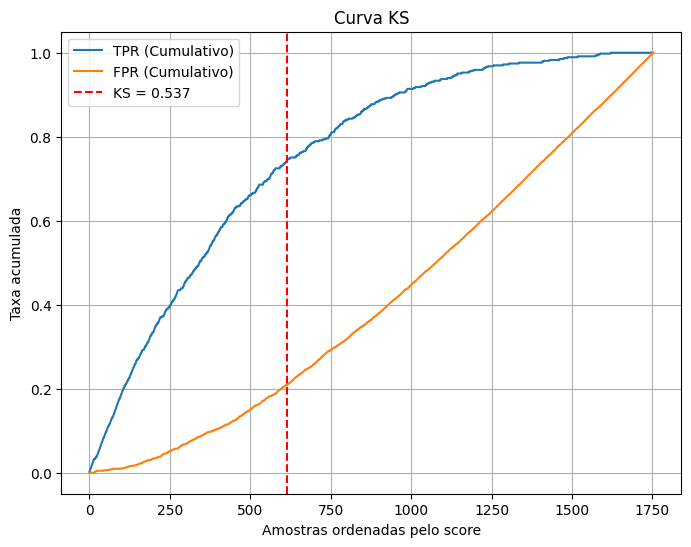

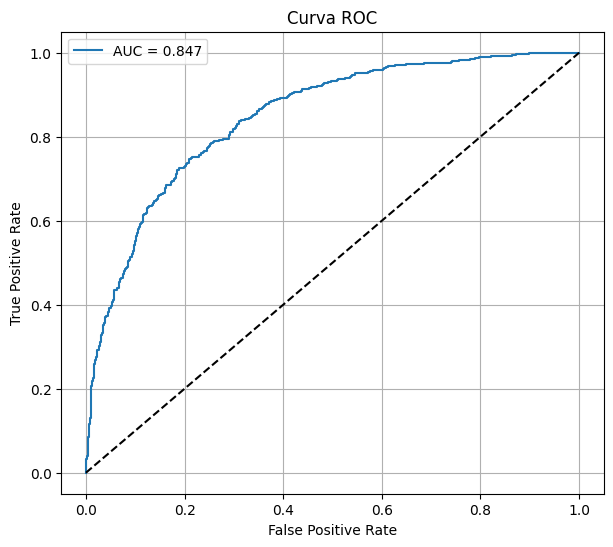

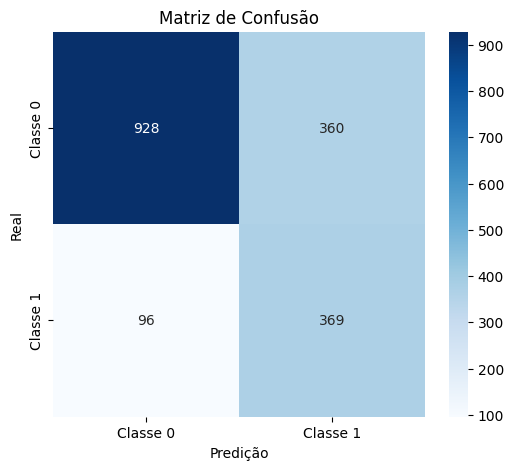

{'ks': np.float64(0.5373856274627663), 'auc': np.float64(0.8466706738796499), 'threshold': 0.5}


In [ ]:

def train_eval_tabkan_1(trial):

    embedding_dim = trial.suggest_categorical("embedding_dim", [16, 32])
    nhead         = trial.suggest_categorical("nhead", [2, 4])
    num_layers    = trial.suggest_int("num_layers", 2, 3)
    dim_ff        = trial.suggest_categorical("dim_feedforward", [64, 128, 256])
    mlp_dim       = trial.suggest_categorical("mlp_hidden", [32, 64, 128])

    lr            = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    weight_decay  = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    batch_size    = trial.suggest_categorical("batch_size", [128, 256, 512])

    # loaders dinâmicos
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=512)

    model = TabKANet(
        output_dim=2,
        vocabulary=vocab,
        num_continuous_features=Xtr_cont.shape[1],
        embedding_dim=embedding_dim,
        nhead=nhead,
        num_layers=num_layers,
        dim_feedforward=dim_ff,
        mlp_hidden_dims=[mlp_dim],
        activation="gelu",
        attn_dropout_rate=0.1,
        ffn_dropout_rate=0.1,
        learninable_noise=True,
        bins=bins
    ).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )

    criterion = nn.CrossEntropyLoss()

    # treino curto (anti-overfit do Optuna)
    for _ in range(7):
        model.train()
        for x_cat, x_cont, y in train_loader:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x_cat, x_cont), y)
            loss.backward()
            optimizer.step()

    # validação
    model.eval()
    probs, labels = [], []

    with torch.no_grad():
        for x_cat, x_cont, y in val_loader:
            x_cat, x_cont = x_cat.to(device), x_cont.to(device)
            p = torch.softmax(model(x_cat, x_cont), dim=1)[:, 1]
            probs.extend(p.cpu().numpy())
            labels.extend(y.numpy())

    ks, _ = ks_2samp(
        np.array(probs)[np.array(labels) == 1],
        np.array(probs)[np.array(labels) == 0]
    )

    results_optuna.append({
        "embedding_dim": embedding_dim,
        "nhead": nhead,
        "num_layers": num_layers,
        "dim_feedforward": dim_ff,
        "mlp_hidden": mlp_dim,
        "lr": lr,
        "weight_decay": weight_decay,
        "batch_size": batch_size,
        "ks": ks
    })


    return ks

results_optuna = []

study = optuna.create_study(direction="maximize")
study.optimize(train_eval_tabkan_1, n_trials=20)

df_optuna = pd.DataFrame(results_optuna)
df_optuna.sort_values("ks", ascending=False).head(10)

print("Melhor KS:", study.best_value)
print("Melhores hiperparâmetros:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")

best_params = study.best_params

trainval_ds = ConcatDataset([train_ds, val_ds])

trainval_loader = DataLoader(
    trainval_ds,
    batch_size=best_params["batch_size"],
    shuffle=True
)

test_loader = DataLoader(test_ds, batch_size=512)

# ─── Modelo ────────────────────────────────────────────────
model = TabKANet(
    output_dim=2,
    vocabulary=vocab,
    num_continuous_features=Xtr_cont.shape[1],
    embedding_dim=best_params["embedding_dim"],
    nhead=best_params["nhead"],
    num_layers=best_params["num_layers"],
    dim_feedforward=best_params["dim_feedforward"],
    mlp_hidden_dims=[best_params["mlp_hidden"]],
    activation="gelu",
    attn_dropout_rate=0.1,
    ffn_dropout_rate=0.1,
    learninable_noise=True,
    bins=bins
).to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=best_params["lr"],
    weight_decay=best_params["weight_decay"]
)

criterion = nn.CrossEntropyLoss()

# ─── Early Stopping ────────────────────────────────────────
PATIENCE = 5
best_val_loss = float("inf")
best_state = None
epochs_no_improve = 0

EPOCHS = 30

history = {
    "train_loss": [],
    "val_loss": [],
    "val_ks": []
}

# ─── Loop de Treino ────────────────────────────────────────
for epoch in range(EPOCHS):

    # ─── Treino ───────────────────────────────────────────
    model.train()
    train_loss = 0.0

    for x_cat, x_cont, y in trainval_loader:
        x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x_cat, x_cont)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(trainval_loader)

    # ─── Validação (LOSS + KS) ─────────────────────────────
    model.eval()
    val_loss = 0.0
    probs, labels = [], []

    with torch.no_grad():
        for x_cat, x_cont, y in val_loader:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)

            logits = model(x_cat, x_cont)
            loss = criterion(logits, y)
            val_loss += loss.item()

            p = torch.softmax(logits, dim=1)[:, 1]
            probs.extend(p.cpu().numpy())
            labels.extend(y.cpu().numpy())

    val_loss /= len(val_loader)

    # KS apenas como métrica
    val_ks = ks_2samp(
        np.array(probs)[np.array(labels) == 1],
        np.array(probs)[np.array(labels) == 0]
    )[0]

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val KS: {val_ks:.4f}"
    )

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_ks"].append(val_ks)

    # ─── Early Stopping (baseado no ERRO) ──────────────────
    if val_loss < best_val_loss - 1e-4:  # tolerância numérica
        best_val_loss = val_loss
        best_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping ativado na epoch {epoch+1}")
        break

# ─── Restaurar melhor modelo ──────────────────────────────
model.load_state_dict(best_state)

model.eval()
probs, labels = [], []

with torch.no_grad():
    for x_cat, x_cont, y in test_loader:
        x_cat, x_cont = x_cat.to(device), x_cont.to(device)

        logits = model(x_cat, x_cont)
        p = torch.softmax(logits, dim=1)[:, 1]

        probs.extend(p.cpu().numpy())
        labels.extend(y.numpy())

y_prob = np.array(probs)
y_true = np.array(labels)

print(f"\nEmbedding dimension: {i}\n")
metrics = plot_model_diagnostics(
    y_true=y_true,
    y_score=y_prob,
    threshold=0.5,
    title_prefix="TabKANet – Teste"
)

print(metrics)

## Experimento 3.5 — Weight Decay

[I 2025-12-18 19:07:36,404] A new study created in memory with name: no-name-1874fea6-7993-41dd-9575-e4fbf4b35776
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
[I 2025-12-18 19:07:39,004] Trial 0 finished with value: 0.5170807453416149 and parameters: {'embedding_dim': 32, 'nhead': 4, 'num_layers': 3, 'dim_feedforward': 128, 'mlp_hidden': 32, 'lr': 0.0016926948075238698, 'weight_decay': 4.503580002803073e-06, 'batch_size': 512}. Best is trial 0 with value: 0.5170807453416149.
[I 2025-12-18 19:07:45,220] Trial 1 finished with value: 0.5527950310559007 and parameters: {'embedding_dim': 32, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 128, 'mlp_hidden': 32, 'lr': 0.00025244837175698306, 'weight_decay': 1.166162466880522e-05, 'batch_size': 128}. Best is trial 1 with value: 0.5527950310559007.
[I 2025-12-18 19:07:49,818] 

Melhor KS: 0.5760869565217391
Melhores hiperparâmetros:
embedding_dim: 32
nhead: 4
num_layers: 2
dim_feedforward: 128
mlp_hidden: 32
lr: 0.004842009958209324
weight_decay: 0.0006142379457069707
batch_size: 128
Epoch 1/30 | Train Loss: 0.5260 | Val Loss: 0.4721 | Val KS: 0.5637
Epoch 2/30 | Train Loss: 0.4926 | Val Loss: 0.4852 | Val KS: 0.5590
Epoch 3/30 | Train Loss: 0.4873 | Val Loss: 0.4592 | Val KS: 0.5807
Epoch 4/30 | Train Loss: 0.4792 | Val Loss: 0.4631 | Val KS: 0.5714
Epoch 5/30 | Train Loss: 0.4766 | Val Loss: 0.4713 | Val KS: 0.5807
Epoch 6/30 | Train Loss: 0.4751 | Val Loss: 0.4606 | Val KS: 0.5839
Epoch 7/30 | Train Loss: 0.4667 | Val Loss: 0.4449 | Val KS: 0.5978
Epoch 8/30 | Train Loss: 0.4631 | Val Loss: 0.4339 | Val KS: 0.6149
Epoch 9/30 | Train Loss: 0.4585 | Val Loss: 0.4422 | Val KS: 0.6211
Epoch 10/30 | Train Loss: 0.4541 | Val Loss: 0.4375 | Val KS: 0.6149
Epoch 11/30 | Train Loss: 0.4546 | Val Loss: 0.4244 | Val KS: 0.6196
Epoch 12/30 | Train Loss: 0.4514 | Val L

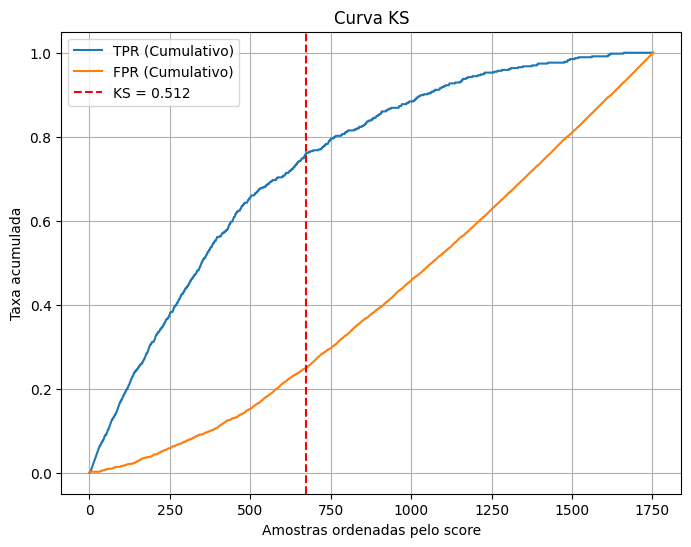

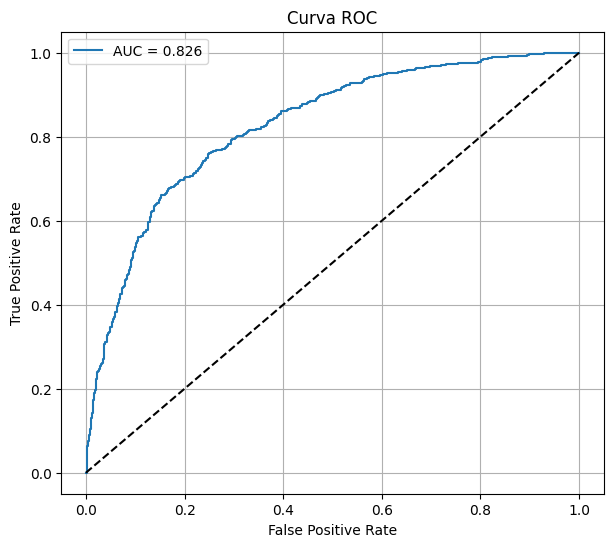

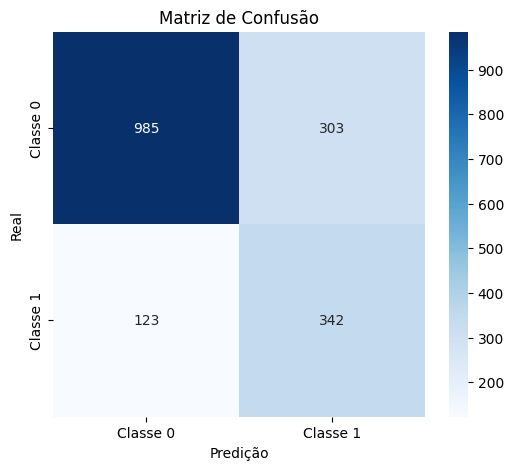

{'ks': np.float64(0.512066720096173), 'auc': np.float64(0.8264409270019368), 'threshold': 0.5}


In [ ]:

def train_eval_tabkan_1(trial):

    embedding_dim = trial.suggest_categorical("embedding_dim", [32])
    nhead         = trial.suggest_categorical("nhead", [4])
    num_layers    = trial.suggest_int("num_layers", 2, 3)
    dim_ff        = trial.suggest_categorical("dim_feedforward", [128])
    mlp_dim       = trial.suggest_categorical("mlp_hidden", [32])

    lr            = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    weight_decay  = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    batch_size    = trial.suggest_categorical("batch_size", [128, 256, 512])

    # loaders dinâmicos
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=512)

    model = TabKANet(
        output_dim=2,
        vocabulary=vocab,
        num_continuous_features=Xtr_cont.shape[1],
        embedding_dim=embedding_dim,
        nhead=nhead,
        num_layers=num_layers,
        dim_feedforward=dim_ff,
        mlp_hidden_dims=[mlp_dim],
        activation="gelu",
        attn_dropout_rate=0.1,
        ffn_dropout_rate=0.1,
        learninable_noise=True,
        bins=bins
    ).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )

    criterion = nn.CrossEntropyLoss()

    # treino curto (anti-overfit do Optuna)
    for _ in range(7):
        model.train()
        for x_cat, x_cont, y in train_loader:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x_cat, x_cont), y)
            loss.backward()
            optimizer.step()

    # validação
    model.eval()
    probs, labels = [], []

    with torch.no_grad():
        for x_cat, x_cont, y in val_loader:
            x_cat, x_cont = x_cat.to(device), x_cont.to(device)
            p = torch.softmax(model(x_cat, x_cont), dim=1)[:, 1]
            probs.extend(p.cpu().numpy())
            labels.extend(y.numpy())

    ks, _ = ks_2samp(
        np.array(probs)[np.array(labels) == 1],
        np.array(probs)[np.array(labels) == 0]
    )

    results_optuna.append({
        "embedding_dim": embedding_dim,
        "nhead": nhead,
        "num_layers": num_layers,
        "dim_feedforward": dim_ff,
        "mlp_hidden": mlp_dim,
        "lr": lr,
        "weight_decay": weight_decay,
        "batch_size": batch_size,
        "ks": ks
    })


    return ks

results_optuna = []

study = optuna.create_study(direction="maximize")
study.optimize(train_eval_tabkan_1, n_trials=20)

df_optuna = pd.DataFrame(results_optuna)
df_optuna.sort_values("ks", ascending=False).head(10)

print("Melhor KS:", study.best_value)
print("Melhores hiperparâmetros:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")

best_params = study.best_params

trainval_ds = ConcatDataset([train_ds, val_ds])

trainval_loader = DataLoader(
    trainval_ds,
    batch_size=best_params["batch_size"],
    shuffle=True
)

test_loader = DataLoader(test_ds, batch_size=512)

# ─── Modelo ────────────────────────────────────────────────
model = TabKANet(
    output_dim=2,
    vocabulary=vocab,
    num_continuous_features=Xtr_cont.shape[1],
    embedding_dim=best_params["embedding_dim"],
    nhead=best_params["nhead"],
    num_layers=best_params["num_layers"],
    dim_feedforward=best_params["dim_feedforward"],
    mlp_hidden_dims=[best_params["mlp_hidden"]],
    activation="gelu",
    attn_dropout_rate=0.1,
    ffn_dropout_rate=0.1,
    learninable_noise=True,
    bins=bins
).to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=best_params["lr"],
    weight_decay=best_params["weight_decay"]
)

criterion = nn.CrossEntropyLoss()

# ─── Early Stopping ────────────────────────────────────────
PATIENCE = 5
best_val_loss = float("inf")
best_state = None
epochs_no_improve = 0

EPOCHS = 30

history = {
    "train_loss": [],
    "val_loss": [],
    "val_ks": []
}

# ─── Loop de Treino ────────────────────────────────────────
for epoch in range(EPOCHS):

    # ─── Treino ───────────────────────────────────────────
    model.train()
    train_loss = 0.0

    for x_cat, x_cont, y in trainval_loader:
        x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x_cat, x_cont)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(trainval_loader)

    # ─── Validação (LOSS + KS) ─────────────────────────────
    model.eval()
    val_loss = 0.0
    probs, labels = [], []

    with torch.no_grad():
        for x_cat, x_cont, y in val_loader:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)

            logits = model(x_cat, x_cont)
            loss = criterion(logits, y)
            val_loss += loss.item()

            p = torch.softmax(logits, dim=1)[:, 1]
            probs.extend(p.cpu().numpy())
            labels.extend(y.cpu().numpy())

    val_loss /= len(val_loader)

    # KS apenas como métrica
    val_ks = ks_2samp(
        np.array(probs)[np.array(labels) == 1],
        np.array(probs)[np.array(labels) == 0]
    )[0]

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val KS: {val_ks:.4f}"
    )

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_ks"].append(val_ks)

    # ─── Early Stopping (baseado no ERRO) ──────────────────
    if val_loss < best_val_loss - 1e-4:  # tolerância numérica
        best_val_loss = val_loss
        best_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping ativado na epoch {epoch+1}")
        break

# ─── Restaurar melhor modelo ──────────────────────────────
model.load_state_dict(best_state)

model.eval()
probs, labels = [], []

with torch.no_grad():
    for x_cat, x_cont, y in test_loader:
        x_cat, x_cont = x_cat.to(device), x_cont.to(device)

        logits = model(x_cat, x_cont)
        p = torch.softmax(logits, dim=1)[:, 1]

        probs.extend(p.cpu().numpy())
        labels.extend(y.numpy())

y_prob = np.array(probs)
y_true = np.array(labels)

print(f"\nEmbedding dimension: {i}\n")
metrics = plot_model_diagnostics(
    y_true=y_true,
    y_score=y_prob,
    threshold=0.5,
    title_prefix="TabKANet – Teste"
)

print(metrics)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 1/7 | Train Loss: 0.5125 | Val Loss: 0.4743 | Val KS: 0.5613
Epoch 2/7 | Train Loss: 0.4917 | Val Loss: 0.4638 | Val KS: 0.5613
Epoch 3/7 | Train Loss: 0.4893 | Val Loss: 0.4626 | Val KS: 0.5807
Epoch 4/7 | Train Loss: 0.4811 | Val Loss: 0.4523 | Val KS: 0.5924
Epoch 5/7 | Train Loss: 0.4798 | Val Loss: 0.4631 | Val KS: 0.5792
Epoch 6/7 | Train Loss: 0.4746 | Val Loss: 0.4521 | Val KS: 0.6087
Epoch 7/7 | Train Loss: 0.4733 | Val Loss: 0.4378 | Val KS: 0.5901

Embedding dimension: 8



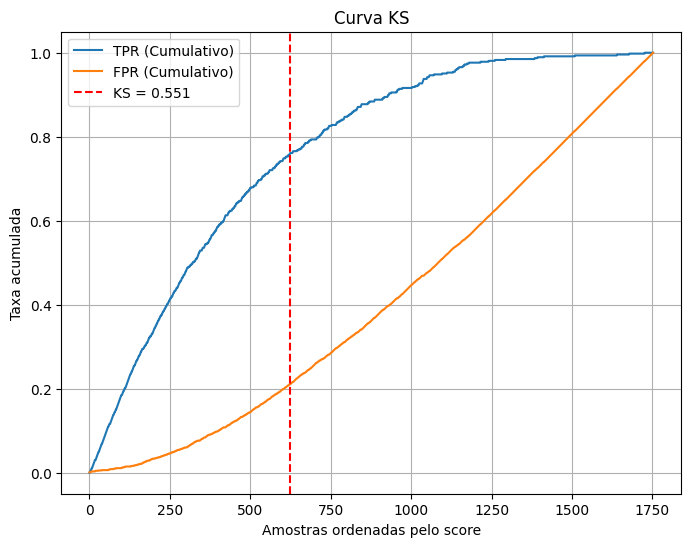

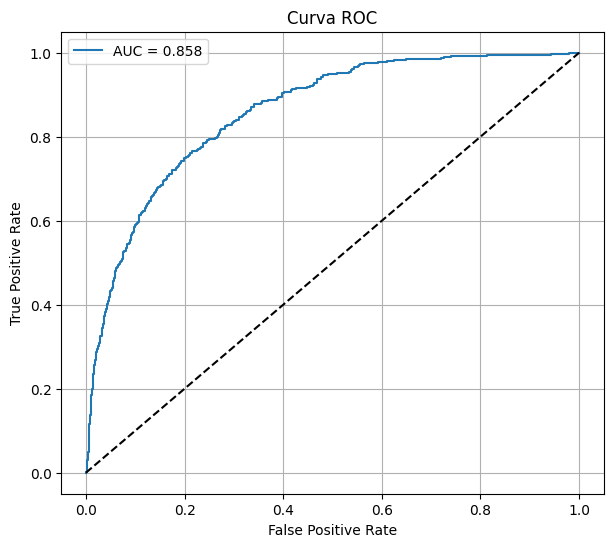

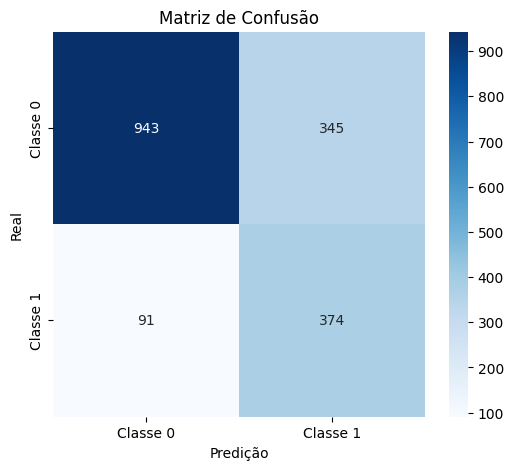

{'ks': np.float64(0.5508865958725706), 'auc': np.float64(0.8583951112001603), 'threshold': 0.5}


In [ ]:
# ─── Modelo ────────────────────────────────────────────────
model = TabKANet(
    output_dim=2,
    vocabulary=vocab,
    num_continuous_features=Xtr_cont.shape[1],
    embedding_dim=best_params["embedding_dim"],
    nhead=best_params["nhead"],
    num_layers=best_params["num_layers"],
    dim_feedforward=best_params["dim_feedforward"],
    mlp_hidden_dims=[best_params["mlp_hidden"]],
    activation="gelu",
    attn_dropout_rate=0.1,
    ffn_dropout_rate=0.1,
    learninable_noise=True,
    bins=bins
).to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=best_params["lr"],
    weight_decay=best_params["weight_decay"]
)

criterion = nn.CrossEntropyLoss()

# ─── Early Stopping ────────────────────────────────────────
PATIENCE = 5
best_val_loss = float("inf")
best_state = None
epochs_no_improve = 0

EPOCHS = 7

history = {
    "train_loss": [],
    "val_loss": [],
    "val_ks": []
}

# ─── Loop de Treino ────────────────────────────────────────
for epoch in range(EPOCHS):

    # ─── Treino ───────────────────────────────────────────
    model.train()
    train_loss = 0.0

    for x_cat, x_cont, y in trainval_loader:
        x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x_cat, x_cont)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(trainval_loader)

    # ─── Validação (LOSS + KS) ─────────────────────────────
    model.eval()
    val_loss = 0.0
    probs, labels = [], []

    with torch.no_grad():
        for x_cat, x_cont, y in val_loader:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)

            logits = model(x_cat, x_cont)
            loss = criterion(logits, y)
            val_loss += loss.item()

            p = torch.softmax(logits, dim=1)[:, 1]
            probs.extend(p.cpu().numpy())
            labels.extend(y.cpu().numpy())

    val_loss /= len(val_loader)

    # KS apenas como métrica
    val_ks = ks_2samp(
        np.array(probs)[np.array(labels) == 1],
        np.array(probs)[np.array(labels) == 0]
    )[0]

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val KS: {val_ks:.4f}"
    )

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_ks"].append(val_ks)

    # ─── Early Stopping (baseado no ERRO) ──────────────────
    if val_loss < best_val_loss - 1e-4:  # tolerância numérica
        best_val_loss = val_loss
        best_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping ativado na epoch {epoch+1}")
        break

# ─── Restaurar melhor modelo ──────────────────────────────
model.load_state_dict(best_state)

model.eval()
probs, labels = [], []

with torch.no_grad():
    for x_cat, x_cont, y in test_loader:
        x_cat, x_cont = x_cat.to(device), x_cont.to(device)

        logits = model(x_cat, x_cont)
        p = torch.softmax(logits, dim=1)[:, 1]

        probs.extend(p.cpu().numpy())
        labels.extend(y.numpy())

y_prob = np.array(probs)
y_true = np.array(labels)

print(f"\nEmbedding dimension: {i}\n")
metrics = plot_model_diagnostics(
    y_true=y_true,
    y_score=y_prob,
    threshold=0.5,
    title_prefix="TabKANet – Teste"
)

print(metrics)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 1/10 | Train Loss: 0.5402 | Val Loss: 0.5097 | Val KS: 0.5668
Epoch 2/10 | Train Loss: 0.4959 | Val Loss: 0.4630 | Val KS: 0.5637
Epoch 3/10 | Train Loss: 0.4903 | Val Loss: 0.4621 | Val KS: 0.5714
Epoch 4/10 | Train Loss: 0.4839 | Val Loss: 0.4640 | Val KS: 0.5823
Epoch 5/10 | Train Loss: 0.4834 | Val Loss: 0.4621 | Val KS: 0.5854
Epoch 6/10 | Train Loss: 0.4785 | Val Loss: 0.4492 | Val KS: 0.5870
Epoch 7/10 | Train Loss: 0.4741 | Val Loss: 0.4622 | Val KS: 0.5753
Epoch 8/10 | Train Loss: 0.4740 | Val Loss: 0.4607 | Val KS: 0.5854
Epoch 9/10 | Train Loss: 0.4667 | Val Loss: 0.4422 | Val KS: 0.6087
Epoch 10/10 | Train Loss: 0.4663 | Val Loss: 0.4353 | Val KS: 0.6134

Embedding dimension: 8



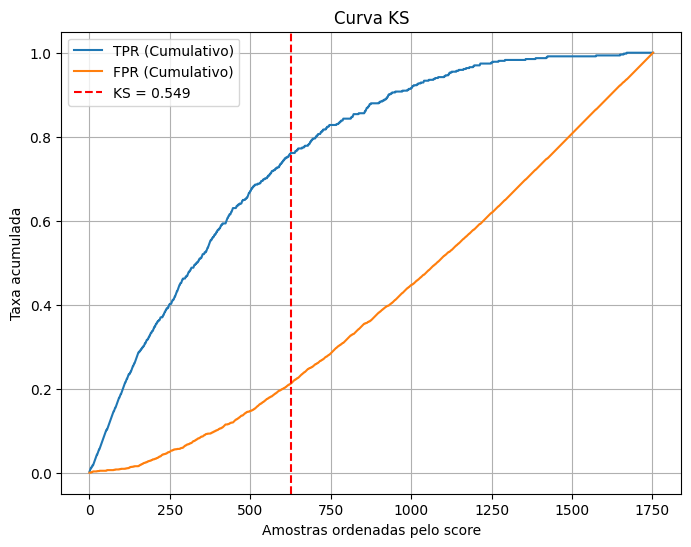

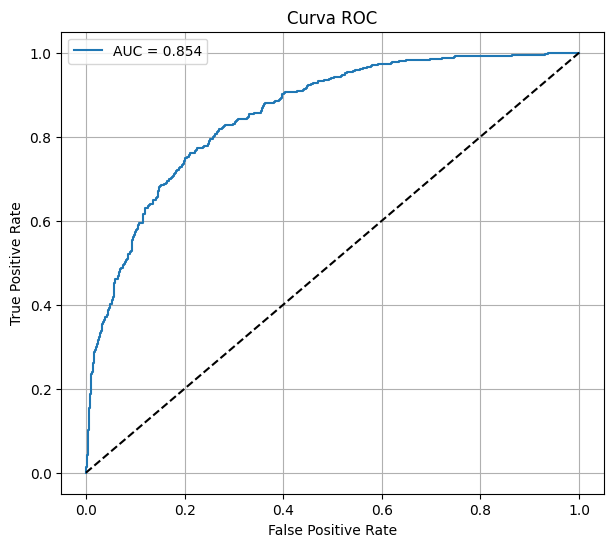

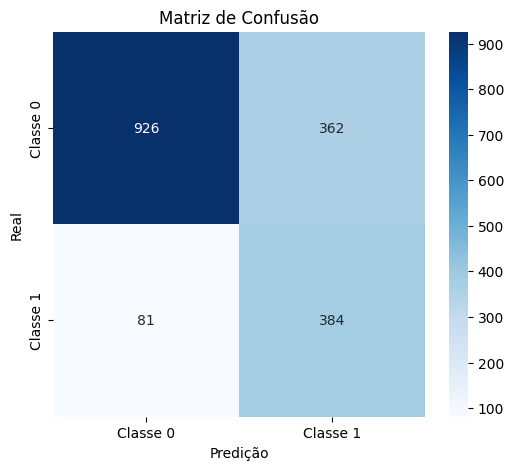

{'ks': np.float64(0.5493338008415147), 'auc': np.float64(0.8542726908435183), 'threshold': 0.5}


In [ ]:
# ─── Modelo ────────────────────────────────────────────────
model = TabKANet(
    output_dim=2,
    vocabulary=vocab,
    num_continuous_features=Xtr_cont.shape[1],
    embedding_dim=best_params["embedding_dim"],
    nhead=best_params["nhead"],
    num_layers=best_params["num_layers"],
    dim_feedforward=best_params["dim_feedforward"],
    mlp_hidden_dims=[best_params["mlp_hidden"]],
    activation="gelu",
    attn_dropout_rate=0.1,
    ffn_dropout_rate=0.1,
    learninable_noise=True,
    bins=bins
).to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=best_params["lr"],
    weight_decay=best_params["weight_decay"]
)

criterion = nn.CrossEntropyLoss()

# ─── Early Stopping ────────────────────────────────────────
PATIENCE = 5
best_val_loss = float("inf")
best_state = None
epochs_no_improve = 0

EPOCHS = 10

history = {
    "train_loss": [],
    "val_loss": [],
    "val_ks": []
}

# ─── Loop de Treino ────────────────────────────────────────
for epoch in range(EPOCHS):

    # ─── Treino ───────────────────────────────────────────
    model.train()
    train_loss = 0.0

    for x_cat, x_cont, y in trainval_loader:
        x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x_cat, x_cont)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(trainval_loader)

    # ─── Validação (LOSS + KS) ─────────────────────────────
    model.eval()
    val_loss = 0.0
    probs, labels = [], []

    with torch.no_grad():
        for x_cat, x_cont, y in val_loader:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)

            logits = model(x_cat, x_cont)
            loss = criterion(logits, y)
            val_loss += loss.item()

            p = torch.softmax(logits, dim=1)[:, 1]
            probs.extend(p.cpu().numpy())
            labels.extend(y.cpu().numpy())

    val_loss /= len(val_loader)

    # KS apenas como métrica
    val_ks = ks_2samp(
        np.array(probs)[np.array(labels) == 1],
        np.array(probs)[np.array(labels) == 0]
    )[0]

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val KS: {val_ks:.4f}"
    )

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_ks"].append(val_ks)

    # ─── Early Stopping (baseado no ERRO) ──────────────────
    if val_loss < best_val_loss - 1e-4:  # tolerância numérica
        best_val_loss = val_loss
        best_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping ativado na epoch {epoch+1}")
        break

# ─── Restaurar melhor modelo ──────────────────────────────
model.load_state_dict(best_state)

model.eval()
probs, labels = [], []

with torch.no_grad():
    for x_cat, x_cont, y in test_loader:
        x_cat, x_cont = x_cat.to(device), x_cont.to(device)

        logits = model(x_cat, x_cont)
        p = torch.softmax(logits, dim=1)[:, 1]

        probs.extend(p.cpu().numpy())
        labels.extend(y.numpy())

y_prob = np.array(probs)
y_true = np.array(labels)

print(f"\nEmbedding dimension: {i}\n")
metrics = plot_model_diagnostics(
    y_true=y_true,
    y_score=y_prob,
    threshold=0.5,
    title_prefix="TabKANet – Teste"
)

print(metrics)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 1/15 | Train Loss: 0.5225 | Val Loss: 0.4814 | Val KS: 0.5551
Epoch 2/15 | Train Loss: 0.4938 | Val Loss: 0.4619 | Val KS: 0.5846
Epoch 3/15 | Train Loss: 0.4886 | Val Loss: 0.4844 | Val KS: 0.5784
Epoch 4/15 | Train Loss: 0.4841 | Val Loss: 0.4659 | Val KS: 0.5800
Epoch 5/15 | Train Loss: 0.4817 | Val Loss: 0.4559 | Val KS: 0.5885
Epoch 6/15 | Train Loss: 0.4801 | Val Loss: 0.4584 | Val KS: 0.5939
Epoch 7/15 | Train Loss: 0.4806 | Val Loss: 0.4493 | Val KS: 0.5939
Epoch 8/15 | Train Loss: 0.4710 | Val Loss: 0.4486 | Val KS: 0.6110
Epoch 9/15 | Train Loss: 0.4692 | Val Loss: 0.4339 | Val KS: 0.5994
Epoch 10/15 | Train Loss: 0.4673 | Val Loss: 0.4592 | Val KS: 0.6157
Epoch 11/15 | Train Loss: 0.4632 | Val Loss: 0.4256 | Val KS: 0.6328
Epoch 12/15 | Train Loss: 0.4603 | Val Loss: 0.4333 | Val KS: 0.6203
Epoch 13/15 | Train Loss: 0.4513 | Val Loss: 0.4435 | Val KS: 0.6421
Epoch 14/15 | Train Loss: 0.4514 | Val Loss: 0.4294 | Val KS: 0.6599
Epoch 15/15 | Train Loss: 0.4498 | Val Loss

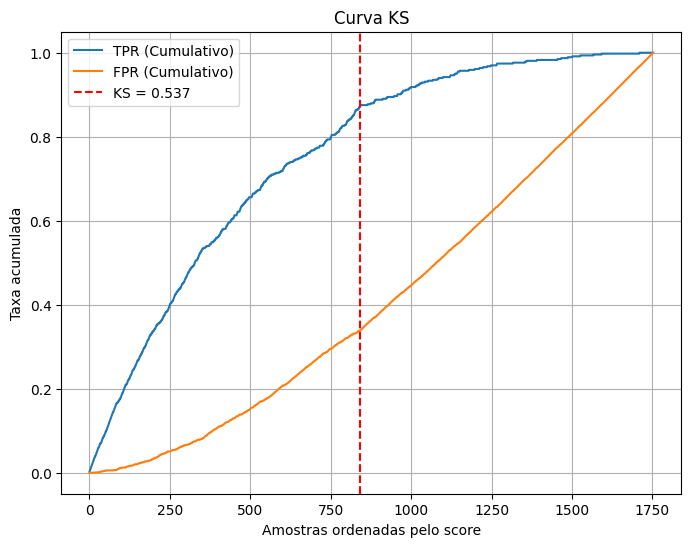

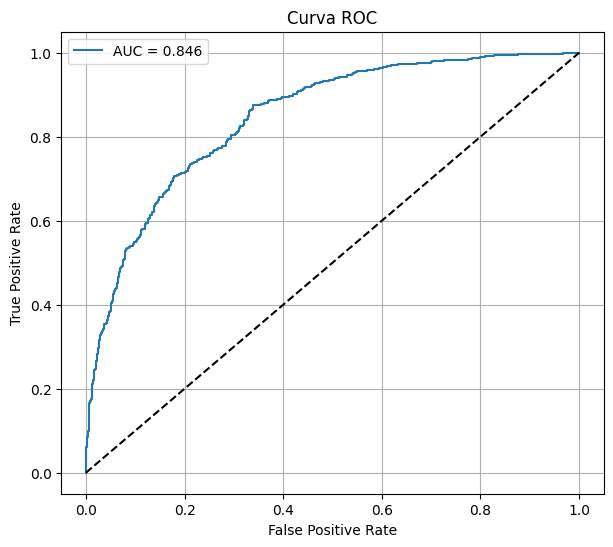

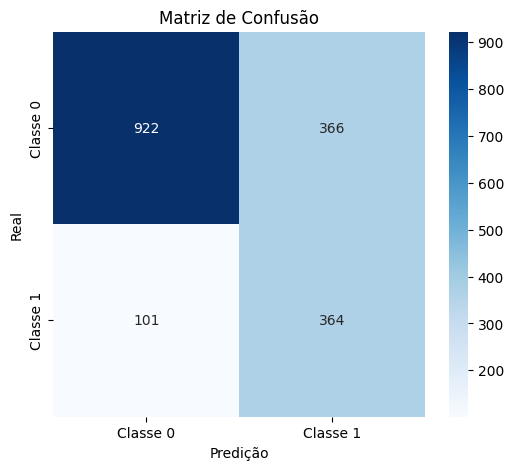

{'ks': np.float64(0.5367595004341148), 'auc': np.float64(0.8464452681493355), 'threshold': 0.5}


In [ ]:
# ─── Modelo ────────────────────────────────────────────────
model = TabKANet(
    output_dim=2,
    vocabulary=vocab,
    num_continuous_features=Xtr_cont.shape[1],
    embedding_dim=best_params["embedding_dim"],
    nhead=best_params["nhead"],
    num_layers=best_params["num_layers"],
    dim_feedforward=best_params["dim_feedforward"],
    mlp_hidden_dims=[best_params["mlp_hidden"]],
    activation="gelu",
    attn_dropout_rate=0.1,
    ffn_dropout_rate=0.1,
    learninable_noise=True,
    bins=bins
).to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=best_params["lr"],
    weight_decay=best_params["weight_decay"]
)

criterion = nn.CrossEntropyLoss()

# ─── Early Stopping ────────────────────────────────────────
PATIENCE = 5
best_val_loss = float("inf")
best_state = None
epochs_no_improve = 0

EPOCHS = 15

history = {
    "train_loss": [],
    "val_loss": [],
    "val_ks": []
}

# ─── Loop de Treino ────────────────────────────────────────
for epoch in range(EPOCHS):

    # ─── Treino ───────────────────────────────────────────
    model.train()
    train_loss = 0.0

    for x_cat, x_cont, y in trainval_loader:
        x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x_cat, x_cont)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(trainval_loader)

    # ─── Validação (LOSS + KS) ─────────────────────────────
    model.eval()
    val_loss = 0.0
    probs, labels = [], []

    with torch.no_grad():
        for x_cat, x_cont, y in val_loader:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)

            logits = model(x_cat, x_cont)
            loss = criterion(logits, y)
            val_loss += loss.item()

            p = torch.softmax(logits, dim=1)[:, 1]
            probs.extend(p.cpu().numpy())
            labels.extend(y.cpu().numpy())

    val_loss /= len(val_loader)

    # KS apenas como métrica
    val_ks = ks_2samp(
        np.array(probs)[np.array(labels) == 1],
        np.array(probs)[np.array(labels) == 0]
    )[0]

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val KS: {val_ks:.4f}"
    )

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_ks"].append(val_ks)

    # ─── Early Stopping (baseado no ERRO) ──────────────────
    if val_loss < best_val_loss - 1e-4:  # tolerância numérica
        best_val_loss = val_loss
        best_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping ativado na epoch {epoch+1}")
        break

# ─── Restaurar melhor modelo ──────────────────────────────
model.load_state_dict(best_state)

model.eval()
probs, labels = [], []

with torch.no_grad():
    for x_cat, x_cont, y in test_loader:
        x_cat, x_cont = x_cat.to(device), x_cont.to(device)

        logits = model(x_cat, x_cont)
        p = torch.softmax(logits, dim=1)[:, 1]

        probs.extend(p.cpu().numpy())
        labels.extend(y.numpy())

y_prob = np.array(probs)
y_true = np.array(labels)

print(f"\nEmbedding dimension: {i}\n")
metrics = plot_model_diagnostics(
    y_true=y_true,
    y_score=y_prob,
    threshold=0.5,
    title_prefix="TabKANet – Teste"
)

print(metrics)